# DATA SCIENTIST TECHNICAL CHALLENGE - MERCADO LIBRE
09/03/2025


JULIÁN CUJABANTE VILLAMIL

# LIBRERIAS

In [1]:
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import seaborn as sns
import optuna
import shap

#Ignorar todos los warnings
warnings.filterwarnings('ignore')

#Supresión el logging de Optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

#Estadística
from scipy import stats
from scipy.stats import (kstest, pointbiserialr, mannwhitneyu, chi2_contingency, 
                         uniform, loguniform, randint)

#Machine Learning - Preprocesamiento
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

#Machine Learning - Modelos
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

#Machine Learning - Evaluación y Métricas
from sklearn.model_selection import (train_test_split, StratifiedKFold, cross_val_score, RandomizedSearchCV)
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score, precision_score, 
                             recall_score, f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, 
                             ConfusionMatrixDisplay)

#Balanceo de Clases
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler


In [2]:
data=pd.read_csv(r'C:\Users\USER}\Downloads\MercadoLibre Data Scientist Technical Challenge - Dataset.csv')
data.head()

,a,b,c,d,e,f,g,h,j,k,l,m,n,o,p,fecha,monto,score,fraude
0,4,0.6812,50084.12,50.0,0.000000,20.0,AR,1,cat_d26ab52,0.365475,2479.0,952.0,1,NaN,Y,2020-03-20 09:28:19,57.63,100,0
1,4,0.6694,66005.49,0.0,0.000000,2.0,AR,1,cat_ea962fb,0.612728,2603.0,105.0,1,Y,Y,2020-03-09 13:58:28,40.19,25,0
2,4,0.4718,7059.05,4.0,0.463488,92.0,BR,25,cat_4c2544e,0.651835,2153.0,249.0,1,Y,Y,2020-04-08 12:25:55,5.77,23,0
3,4,0.7260,10043.10,24.0,0.046845,43.0,BR,43,cat_1b59ee3,0.692728,4845.0,141.0,1,N,Y,2020-03-14 11:46:13,40.89,23,0
4,4,0.7758,16584.42,2.0,0.154616,54.0,BR,0,cat_9bacaa5,0.201354,2856.0,18.0,1,Y,N,2020-03-23 14:17:13,18.98,71,0


In [3]:
data.shape

(150000, 19)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 19 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   a       150000 non-null  int64  
 1   b       137016 non-null  float64
 2   c       137016 non-null  float64
 3   d       149635 non-null  float64
 4   e       150000 non-null  float64
 5   f       149989 non-null  float64
 6   g       149806 non-null  object 
 7   h       150000 non-null  int64  
 8   j       150000 non-null  object 
 9   k       150000 non-null  float64
 10  l       149989 non-null  float64
 11  m       149635 non-null  float64
 12  n       150000 non-null  int64  
 13  o       41143 non-null   object 
 14  p       150000 non-null  object 
 15  fecha   150000 non-null  object 
 16  monto   150000 non-null  float64
 17  score   150000 non-null  int64  
 18  fraude  150000 non-null  int64  
dtypes: float64(9), int64(5), object(5)
memory usage: 21.7+ MB


In [5]:
data['fecha'] = pd.to_datetime(data['fecha'])
cat_cols=['a', 'g', 'j', 'n', 'o', 'p']
data[cat_cols] = data[cat_cols].astype('category')

Hay una total de 19 variables incluyendo la variable objetivo (fraude).
Para algunas de las variables, el tipo de datos fue interpretado por python de manera errónea, por ejemplo la variable n es categórica binaria con valores de 0 y 1, pero python la interpretó como un entero. Esto no es del todo cierto, pues querría decir que los valores guardan una relación lineal y numérica, lo cual no es cierto. Por tal motivo se cambiará a lo largo del notebook el tipo de estas variables.

In [6]:
df_original = data.copy()

Se crea una copia del data frame original para usar este para el análsis de las variables en el EDA. La razón de esto es que a lo largo del notebook en los analisis se irán creando variables nuevas, y pues para evitar analizar esta varaibles recien creadas.

In [7]:
numerical_features = df_original.select_dtypes(include=['number']).drop(columns=['fraude']).columns

In [8]:
categorical_features = df_original.select_dtypes(include=['category']).columns

## DISTRIBUCIÓN DE LA ETIQUETA DE FRAUDE

,Conteos,Porcentaje (%)
fraude,,
0,142500,95.0
1,7500,5.0


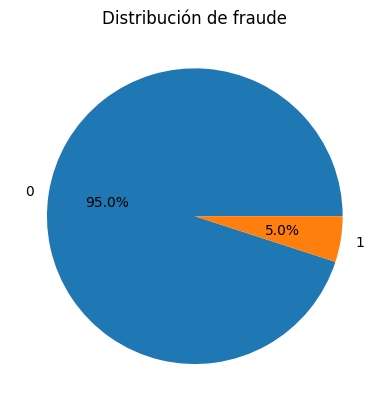

In [9]:
data['fraude'].value_counts(normalize=True).plot(kind='pie', autopct='%1.1f%%', title="Distribución de fraude", ylabel='')

value_counts = data['fraude'].value_counts()
percentages = data['fraude'].value_counts(normalize=True) * 100

results = pd.DataFrame({'Conteos': value_counts, 'Porcentaje (%)': percentages})
results

Como puede observarse, hay un claro desbalance en la etiqueta de fraude. Siendo esta apenas el 5% del total de resgitros. Este hecho nos conduce a un escenario de desbalance de clases muy común en el fraude, el cual de no ser tratado puede llevar a problemas de underfitting en el modelo, pues este tendrá una sobrerepresentación de la etiqueta mayoritaria aprendiendo que todo lo que se pase a el, sea de esa misma etiqueta.

## DATOS DUPLICADOS

In [10]:
data.duplicated().sum()

0

No hay presencia de datos duplicados en el dataset

## ANÁLISIS DE DATOS FALTANTES

In [11]:
#Se calcula la cantidad de valores faltantes y la proporción a la que ascienden por variable.
total_nulos = df_original.isnull().sum()
missing_percentage = (total_nulos / len(data)) * 100

missings_data = pd.DataFrame({'Valores Faltantes': total_nulos, 'Porcentaje (%)': missing_percentage})
missings_data = missings_data[missings_data['Valores Faltantes'] > 0].sort_values(by='Porcentaje (%)', ascending=False)

missings_data

,Valores Faltantes,Porcentaje (%)
o,108857,72.571333
b,12984,8.656000
c,12984,8.656000
d,365,0.243333
m,365,0.243333
g,194,0.129333
f,11,0.007333
l,11,0.007333


Se tabula para las variables con presencia de valores nulos a cuantos ascienden y que porcentaje del total de registros por variable representan.
Se puede observar que la variable con mayor cantidad de datos faltantes es 'o' que equivalen al 72.5% de su distribución. Seguida por las variables 'b' y 'c' que tienen la misma cantidad de datos faltantes que asciende al 8.6% de su distribución.
Las demás variables presentan datos faltantes en menos del 5% de su distribución.
De esta manera nos enfrentamos a un problema de calidad de datos notorio. Pues el porcentaje de datos faltantes de algunas de las variables lleva a cuestionarse sobre la utilidad de la variable, como es el caso 'o'.
Antes de tomar una decisión sobre que hacer con estos datos faltantes se revisará si la presencia de datos faltantes en estas variables guarda o no algún tipo de relación con la variable objetivo.
Para ello se calculará la tasa de fraude de los valores faltantes para cada una de las variables en donde hay missings. En otras palabras la razón entre los registros fraudulentos nulos de cada variable y los valores nulos de esa misma variable.
Asimismo, se calculará de igual manera la tasa de fraude para los valores no nulos por variable.
Esto permitirá comparar que tan frecuente es el fraude en los valores nulos y empezar a entender si existe una relación entre el valor faltante y el fraude.

In [12]:
#Ya se calculo el total de registros faltantes por variable en total_nulos

#Total de transacciones con valores nulos que son fraude por variable.
fraud_nulos = df_original[df_original['fraude'] == 1].isnull().sum()

#Tasa de fraude de los valores nulos por variable
fraud_rate_if_missing = (fraud_nulos / total_nulos) * 100

#Total de registros no nuos por variable.
total_no_nulos = df_original.notnull().sum()
#Total de transacciones con valores no nulos que son fraude pro variable
fraud_no_nulos = df_original[df_original['fraude'] == 1].notnull().sum()

#Tasa de fraude de los valores no nulos por variable.
fraud_rate_if_not_missing = (fraud_no_nulos / total_no_nulos) * 100

#Diferencia entre tasas de fraude y comparación
fraud_rate_comparison = pd.DataFrame({
    'Tasa Fraude (%) cuando es nulo': fraud_rate_if_missing,
    'Tasa Fraude (%) cuando NO es nulo': fraud_rate_if_not_missing,
    'Diferencia (%)': fraud_rate_if_missing - fraud_rate_if_not_missing
}).dropna()

fraud_rate_comparison


,Tasa Fraude (%) cuando es nulo,Tasa Fraude (%) cuando NO es nulo,Diferencia (%)
b,6.384781,4.868774,1.516007
c,6.384781,4.868774,1.516007
d,7.945205,4.992816,2.952390
f,0.000000,5.000367,-5.000367
g,7.731959,4.996462,2.735497
l,0.000000,5.000367,-5.000367
m,7.945205,4.992816,2.952390
o,2.054990,12.791969,-10.736980


Cuando la diferencia entre ambas tasas de fraude es positiva, nos indica que la ausencia del dato en esa variable aumenta la probabilidad de que ocurra el fraude. De manera análoga, cuando el valor de la diferencia es negativa nos indica que la ausencia del dato en esa columna reduce la probabilidad de fraude.

Vemos así que parece ser que la tasa de fraude de los valores nulos en las variables con datos faltantes parece estar relacionado de alguna manera con el fraude.
Por tal motivo, el simplemente eliminar estos registros como se recomendarse a veces en presencia de datos faltantes, podría incurrir en una perdida de valiosa información.
Por tal motivo, se decide crear variables binarias que toman el valor de 1 cuando el dato es nulo en la columna original y cero de lo contrario, para las variables que presentaron una diferencia entre tasas de fraude mayor a 0 y en la variable o que presenta datos faltantes iguales al 72% de su distribución (imputar datos en esta variable no es tan factible, pues se estaría imputando una cantidad muy elevada de valores respecto a su distribución lo cual definitivamente cambiaría la variable y la posible relación de esta con la variable objetivo.

In [13]:
#Creación de las variables binarias categóricas para capturar la relación de los valores nulos de las variables y fraude.
for column in fraud_rate_comparison.index:
    
    data[f'{column}_missing'] = data[column].isnull().astype('category')


Se realiza una prueba chi cuadrado sobre las variables recién creadas y la variable fraude, para corroborar si relación entre estas.

In [14]:
chi2_results_list = []
for column in fraud_rate_comparison.index:

    col_name = f'{column}_missing'
    
    #Tabla de contingencia entre la columna binaria fraude
    contingency_table = pd.crosstab(data[col_name], data['fraude'])
    
    #Prueba Chi-cuadrado
    chi2, p, _, _ = stats.chi2_contingency(contingency_table)
    
    chi2_results_list.append({
        'Variable': col_name,
        'Chi2': chi2,
        'p-valor': p
    })

chi2_results_df = pd.DataFrame(chi2_results_list)
chi2_results_df

,Variable,Chi2,p-valor
0,b_missing,57.066132,4.214005e-14
1,c_missing,57.066132,4.214005e-14
2,d_missing,6.074623,1.371376e-02
3,f_missing,0.004785,9.448511e-01
4,g_missing,2.503509,1.135929e-01
5,l_missing,0.004785,9.448511e-01
6,m_missing,6.074623,1.371376e-02
7,o_missing,7244.297024,0.000000e+00


Al revisar los valores vemos que tanto que los valores de chi cuadrado en algunas variables es alto, y coincide también con un valor muy bajo de p-valor que rechaza la H0, permitiendonos concluir que en estos casos esa variable si guarda una relación con la variable objetivo. Este es el caso de variables como 'b_missing_pos', 'c_missing
', etc.

No obstante, la prueba también nos muestra que quizá no existe alguna relación entre los valores faltantes de las variables 'f', 'g' y 'l' con la variable fraude.

En ese orden de ideas se podrían incluir en el modelo las variables relacionadas con fraude.

In [15]:
data=data.drop(['f_missing', 'g_missing', 'l_missing'], axis=1)

Se eliminan las variables que no guardan relación con fraude

Se explora la relación de la variable fecha con los valores faltantes

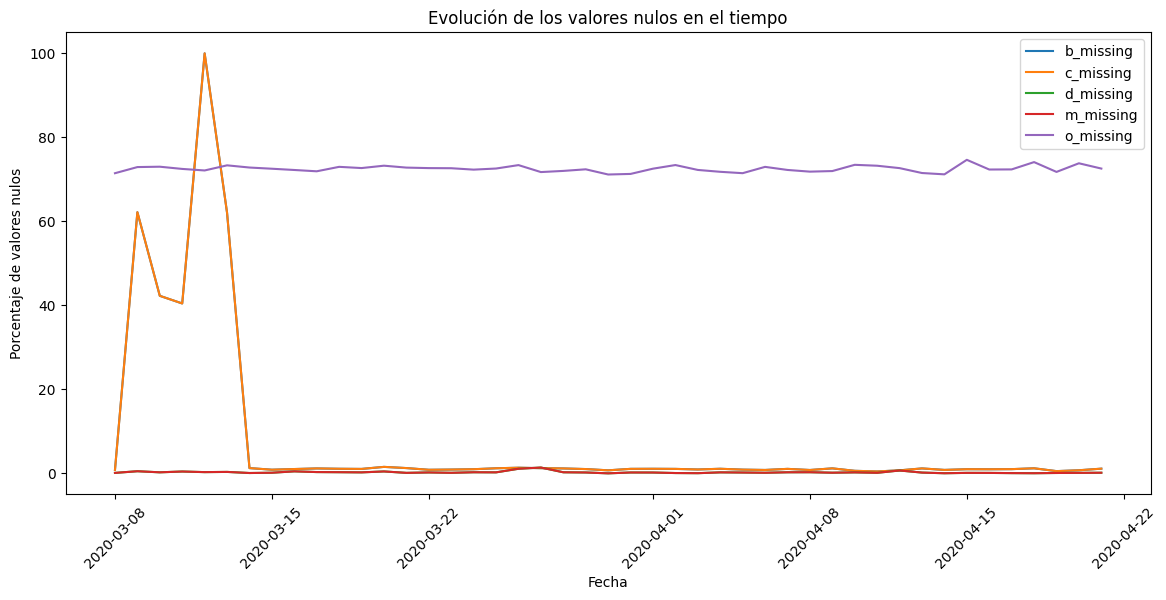

In [16]:
#Se agrupa por fecha y se calcula el porcentaje de valores nulos en cada día
missing_over_time = data.groupby(data['fecha'].dt.date)[['b_missing', 'c_missing', 'd_missing', 'm_missing', 'o_missing']].apply(lambda group: group.astype(int).mean()) * 100

#Se grafica la evolución de los valores nulos a lo largo del tiempo
plt.figure(figsize=(14, 6))
for column in missing_over_time.columns:
    plt.plot(missing_over_time.index, missing_over_time[column], label=column)

plt.xlabel("Fecha")
plt.ylabel("Porcentaje de valores nulos")
plt.title("Evolución de los valores nulos en el tiempo")
plt.legend()
plt.xticks(rotation=45)
plt.show()

Sólo una variable c_missing muestra una relación en un breve periodo de tiempo. Esto podría indicar que se pudo deber a un error técnico o a un evento especial o algo muy puntual. el resto de las variables tienen un comportamiento casi constante en el tiempo.

## OUTLIERS

In [17]:
#Outliers usando el método del IQR
outlier_counts = []

for column in numerical_features:
    Q1 = df_original[column].quantile(0.25)
    Q3 = df_original[column].quantile(0.75)
    IQR = Q3 - Q1
    
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    num_outliers = ((df_original[column] < lower_bound) | (df_original[column] > upper_bound)).sum()
    total_values = df_original[column].count()
    
    outlier_percentage = (num_outliers / total_values) * 100 if total_values > 0 else 0

    outlier_counts.append((column, num_outliers, total_values, outlier_percentage))


outlier_data = pd.DataFrame(outlier_counts, columns=[
    'Variable', 'Número de Outliers', 'Total de Valores', 'Porcentaje de Outliers (%)'
])

outlier_data = outlier_data.sort_values(by='Porcentaje de Outliers (%)', ascending=False).reset_index(drop=True)
outlier_data = outlier_data.query("`Número de Outliers` > 0")
outlier_data

,Variable,Número de Outliers,Total de Valores,Porcentaje de Outliers (%)
0,c,16946,137016,12.367899
1,f,17116,149989,11.411504
2,monto,14823,150000,9.882000
3,b,8554,137016,6.243067
4,e,7580,150000,5.053333
5,h,5045,150000,3.363333
6,m,4499,149635,3.006650
7,l,384,149989,0.256019


Como se puede observar hay tres variables que tienen un porcentaje de outliers o bien superando el 10% de su distribución o cercano a este valor.
La presencia de valores atípicos puede llegar a interferir en el entrenamiento y aprendizaje de ciertos modelos como los SVM, Regresión Logística, entre otros.
Si bien los modelos arbóreos son más resilientes a este problema de calidad de datos, evaluar el comportamiento de estos puede llevar a encontrar posibles relaciones entre la variable y fraude. Más adelante se tratará este problema.

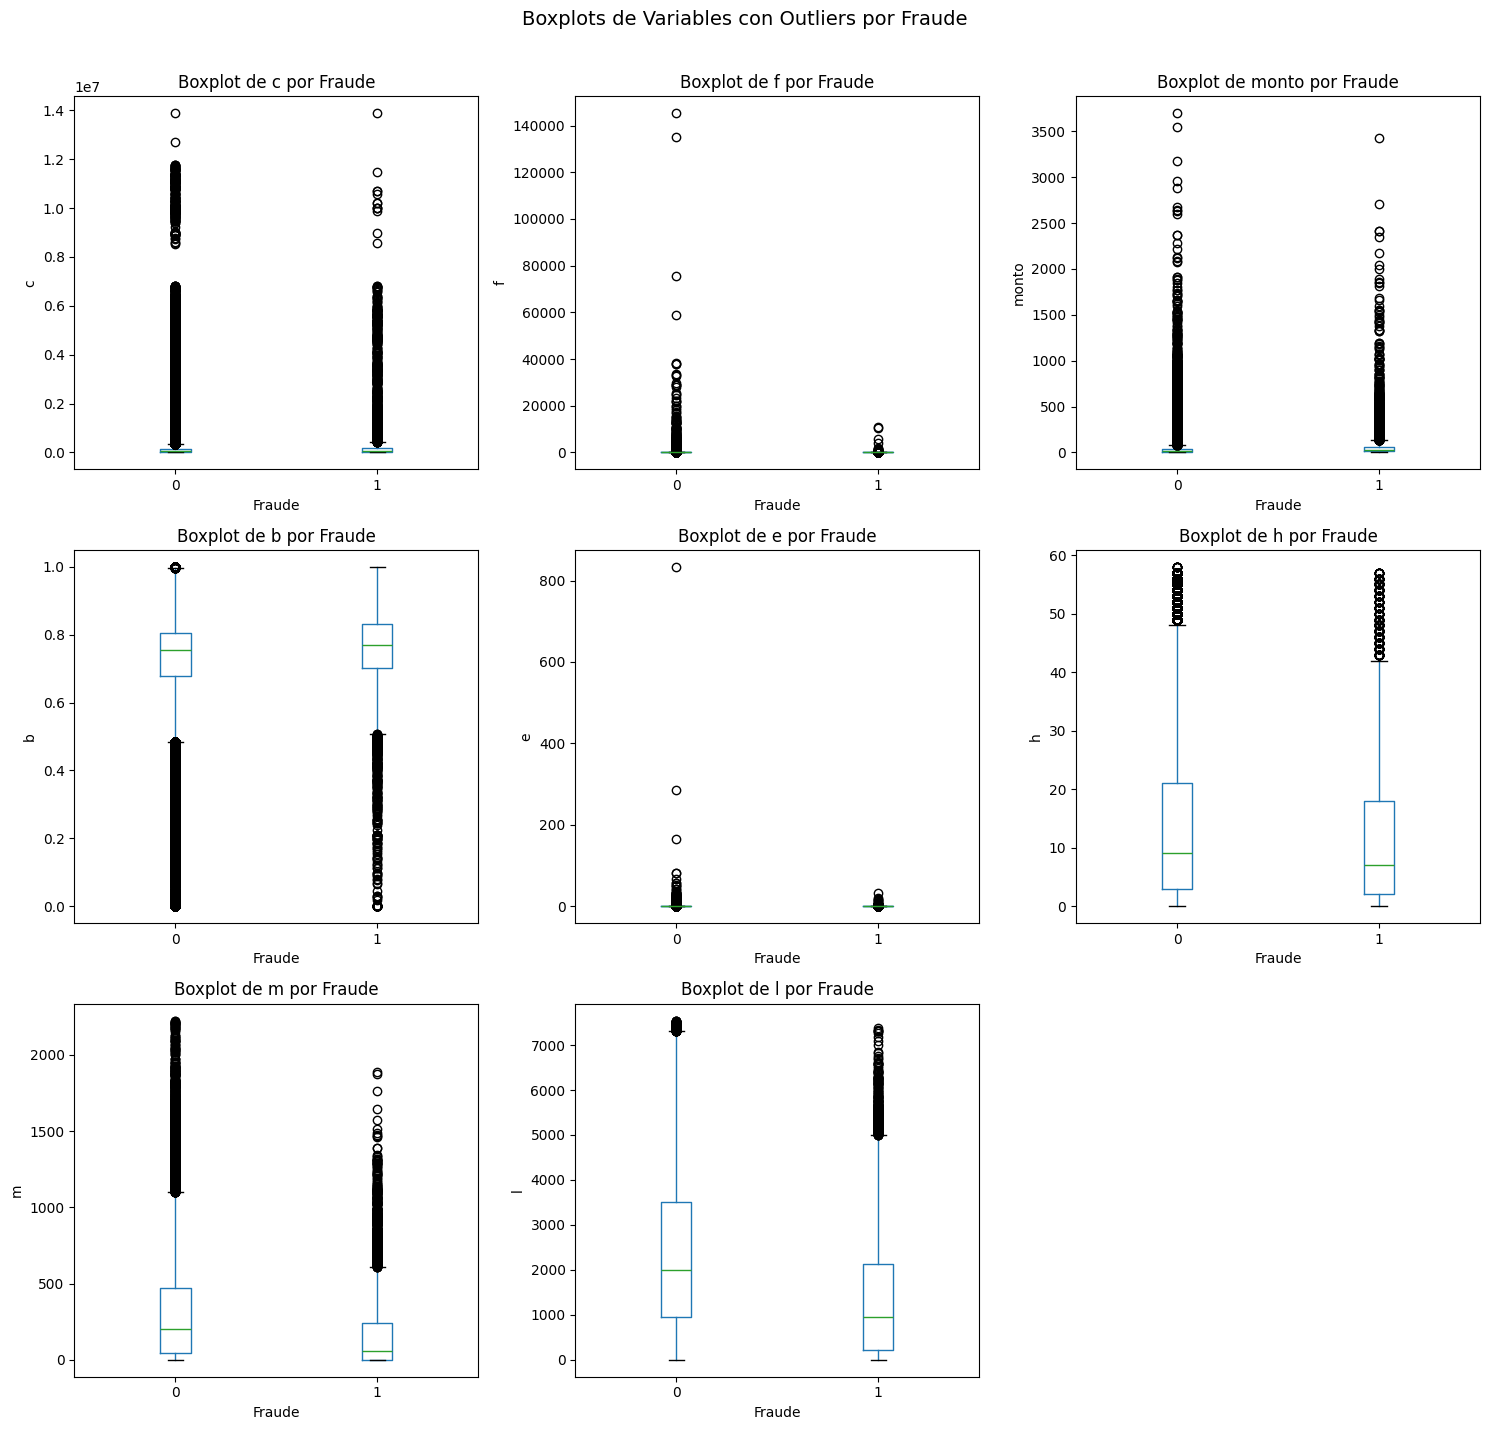

In [18]:
num_vars = len(outlier_data)


num_cols = 3  
num_rows = -(-num_vars // num_cols)  


fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  


for i, row in enumerate(outlier_data.itertuples()):
    col = row.Variable 
    df_original.boxplot(column=col, by="fraude", ax=axes[i])
    axes[i].set_title(f"Boxplot de {col} por Fraude")
    axes[i].set_xlabel("Fraude")
    axes[i].set_ylabel(col)
    axes[i].grid(False)

#Eliminación ejes vacíos en caso de que sobren
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])


plt.suptitle("Boxplots de Variables con Outliers por Fraude", fontsize=14)
plt.tight_layout(rect=[0, 0.03, 1, 0.97])
plt.show()

Al graficar las variables con outliers contrastando con fraude, vemso que en algunas pueden llegar a verse tendencias desde la inspección gráfica como en la variable 'm' y 'l'. Por otro lado, en la mayoría de las variables la presencia de lso outliers se da luego del percentil 75.

si ahondamos más en la comparación entre las distribuciones por variable con outliers frente a fraude, usando la tasa de fraude.

In [19]:
fraude_outliers_list = []

for _, row in outlier_data.iterrows():
    col = row['Variable']
    
    Q1 = df_original[col].quantile(0.25)
    Q3 = df_original[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR  
    upper_bound = Q3 + 1.5 * IQR  
    
    #Filtro de outliers
    outliers = df_original[(df_original[col] < lower_bound) | (df_original[col] > upper_bound)]
    normal = df_original.loc[~df_original.index.isin(outliers.index)]
    
    #Tasas de fraude
    tasa_fraude_outliers = outliers["fraude"].mean()
    tasa_fraude_normal = normal["fraude"].mean()   

    fraude_outliers_list.append({
        "Variable": col,
        "Tasa Fraude (Outliers)": tasa_fraude_outliers,
        "Tasa Fraude (Normal)": tasa_fraude_normal,
        "Diferencia (%)": (tasa_fraude_outliers - tasa_fraude_normal) * 100
    })

fraude_outliers_df = pd.DataFrame(fraude_outliers_list)
fraude_outliers_df

,Variable,Tasa Fraude (Outliers),Tasa Fraude (Normal),Diferencia (%)
0,c,0.066564,0.047890,1.867405
1,f,0.017936,0.054130,-3.619348
2,monto,0.089118,0.045710,4.340782
3,b,0.081482,0.048096,3.338625
4,e,0.050923,0.049951,0.097263
5,h,0.038454,0.050402,-1.194793
6,m,0.018226,0.050982,-3.275619
7,l,0.015625,0.050088,-3.446323


Se puede observar que en algunas variables la diferencia en tasa de fraude es de casi el 5% como en el caso de monto. Esto nos indica que es posible que los valores altos (ver boxplot) de las transacciones estén relacionadas con el fraude, como también en el caso de b (valores bajos, ver boxplot).

## ANÁLISIS DE DATOS TIPO FECHA

Se decide construir otras variables a partir de la variable fecha con el fin de evaluar si existe una relación entre la temporalidad y el fraude.
Lo primero que se hace es entonces ver como se distribuye el fraude en el tiempo. contrastado con el monto.

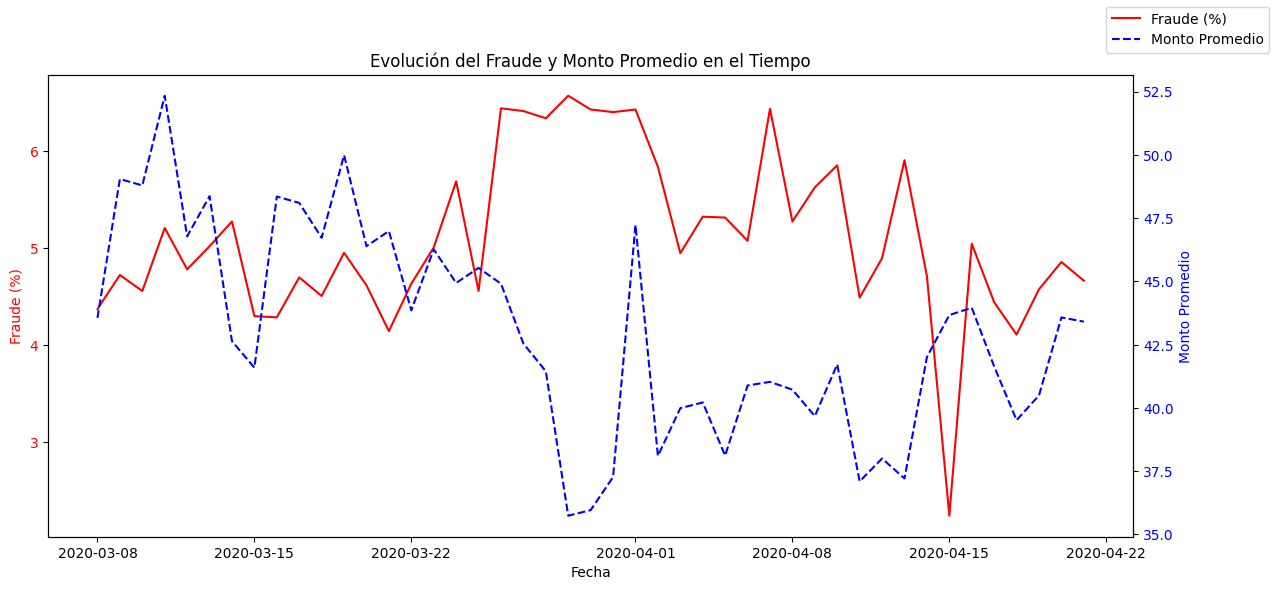

In [20]:
#Porcentaje de fraudes en el tiempo
fraud_rate_per_day = data.groupby(data['fecha'].dt.date)['fraude'].mean() * 100

#Monto promedio en el tiempo
monto_avg_per_day = data.groupby(data['fecha'].dt.date)['monto'].mean()


#Grafica de la evolución del fraude y el monto promedio en el tiempo
fig, ax1 = plt.subplots(figsize=(14, 6))

ax1.set_xlabel("Fecha")
ax1.set_ylabel("Fraude (%)", color="red")
ax1.plot(fraud_rate_per_day.index, fraud_rate_per_day, color="red", label="Fraude (%)")
ax1.tick_params(axis="y", labelcolor="red")

ax2 = ax1.twinx()
ax2.set_ylabel("Monto Promedio", color="blue")
ax2.plot(monto_avg_per_day.index, monto_avg_per_day, color="blue", label="Monto Promedio", linestyle="dashed")
ax2.tick_params(axis="y", labelcolor="blue")

fig.legend(loc="upper right")
plt.title("Evolución del Fraude y Monto Promedio en el Tiempo")
plt.show()

Si bien hay una relación inversa entr emonto y fraude cerca del final de marzo y principios de abril, no se ve gráficamente alguna tendencia o patrón entre el monto y el fraude en el tiempo. Se desacarta así que pudiera existir una relación de este con un evento o fecha especial, como podria ocurrir n fechas de altas ventas como un blackfriday o temporada de navidad.

Se construye ahora la variable de 'dia_semana' para investigra más sobre la posible relación entr eel día de la semana y fraude

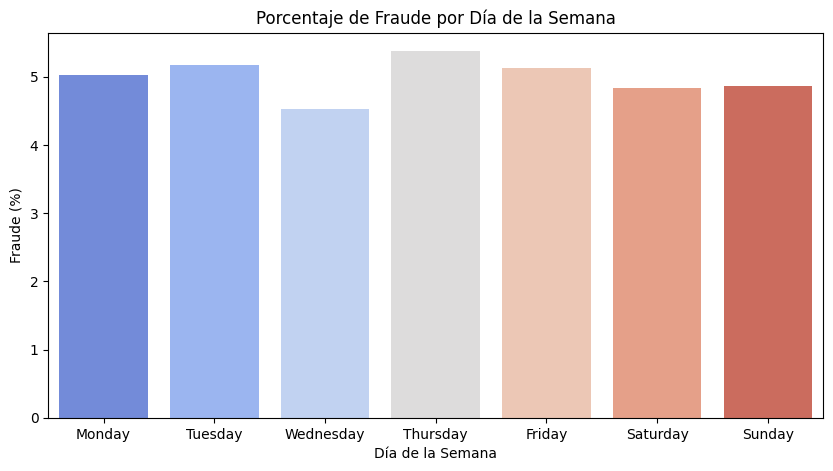

In [21]:
#Se crea la variable día de la semana a partir de la variable fecha
data['dia_semana'] = data['fecha'].dt.day_name()

#Se Calcula la tasa de fraude por día de la semana
fraud_rate_by_weekday = data.groupby('dia_semana')['fraude'].mean() * 100

#Se Reordenan los días de la semana
fraud_rate_by_weekday = fraud_rate_by_weekday.reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

#Gráfica de fraude según el día de la semana
plt.figure(figsize=(10, 5))
sns.barplot(x=fraud_rate_by_weekday.index, y=fraud_rate_by_weekday.values, palette="coolwarm")
plt.xlabel("Día de la Semana")
plt.ylabel("Fraude (%)")
plt.title("Porcentaje de Fraude por Día de la Semana")
plt.show()

Visualmente se puede observar que hay unos días que tienen un mayor % de fraude como lo es el caso del jueves. No obstante, para estar seguros que esta variable si aportará valor se le aplicará una prueba de chi cuadrado frente a fraude.

In [22]:
#Prueba de Chi cuadrado entre días de la semana y fraude
contingency_weekday = pd.crosstab(data['dia_semana'], data['fraude'])
chi2_weekday, p_weekday, _, _ = stats.chi2_contingency(contingency_weekday)

#Fraude por día de la semana
fraud_weekday_table = pd.DataFrame({'Fraude (%)': fraud_rate_by_weekday})

chi2_results = pd.DataFrame({
    'Fraude (%)': [chi2_weekday, p_weekday]
}, index=['Chi2', 'p-valor'])
fraud_weekday_table = pd.concat([fraud_weekday_table, chi2_results])

fraud_weekday_table

,Fraude (%)
Monday,5.028214
Tuesday,5.168573
Wednesday,4.532948
Thursday,5.378580
Friday,5.134381
Saturday,4.831959
Sunday,4.863049
Chi2,20.644715
p-valor,0.002125


El p valor es bajo lo que nos permite rechazar H0 indicando que si existe una relación entre día de la semana y fraude

Se crea ahora la variable hora en base a la columna fecha, esto para evaluar si existe una posible relación entre la hora del día y el fraude. Lo primero que se hace es ver las distribuciones a lo largo de las horas del día entre las transacciones fraude de las no fraude.

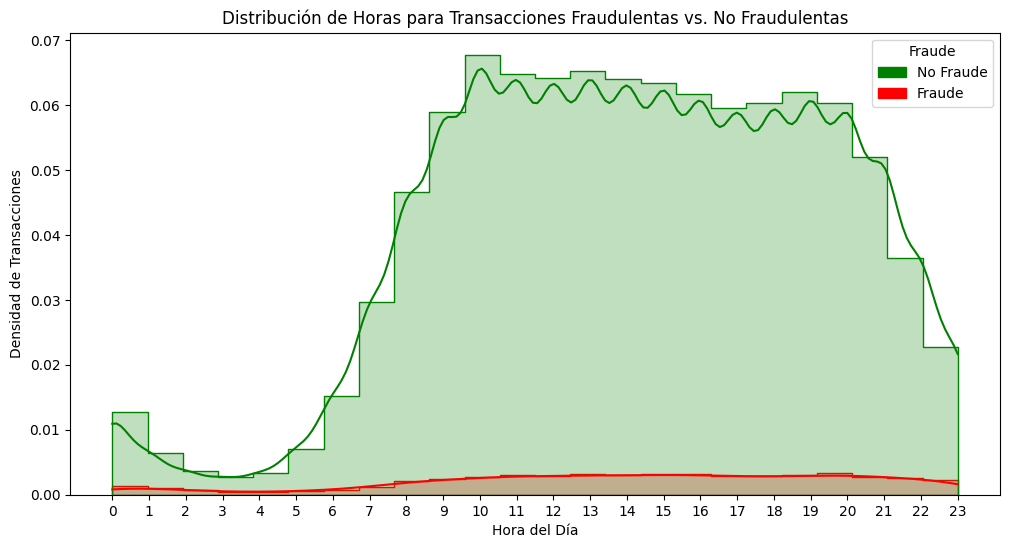

In [23]:
#Se crea la variable hora
data['hora'] = data['fecha'].dt.hour

plt.figure(figsize=(12, 6))

ax = sns.histplot(data=data, x="hora", hue=data["fraude"].replace({0: "No Fraude", 1: "Fraude"}), 
                   bins=24, kde=True, element="step", stat="density", palette={"No Fraude": "green", "Fraude": "red"})

plt.xlabel("Hora del Día")
plt.ylabel("Densidad de Transacciones")
plt.title("Distribución de Horas para Transacciones Fraudulentas vs. No Fraudulentas")
plt.xticks(range(0, 24))

handles, labels = ax.get_legend_handles_labels()
if not handles:
    handles = [Patch(color="green", label="No Fraude"), Patch(color="red", label="Fraude")]
plt.legend(handles=handles, title="Fraude", loc="upper right")

plt.show()

Visualmente se ve que en si las distribuciones son diferentes entre las transacciones legitimas y las fraudulentas. Se corroborará esto con un Ks test y un test de Mann-Whitney U. Por un lado el primer test nos dirá si las distribuciones son diferentes y el segundo test nos indicará si las transacciones fraudulentas ocurren en horas que son significativamente distintas a las transaccione no fraude.

In [24]:
#Horas de fraude y no fraude
hora_fraud = data[data['fraude'] == 1]['hora']
hora_legit = data[data['fraude'] == 0]['hora']

#Ks test de distribuciones
ks_stat, p_value_ks = stats.ks_2samp(hora_fraud, hora_legit)

#Prueba de Mann-Whitney U
mw_stat, p_value_mw = mannwhitneyu(hora_fraud, hora_legit, alternative='two-sided')


stat_tests_result = pd.DataFrame({
    'Estadístico': [ks_stat, mw_stat],
    'p-Valor': [p_value_ks, p_value_mw]
}, index=["Kolmogorov-Smirnov", "Mann-Whitney U"])


stat_tests_result

,Estadístico,p-Valor
Kolmogorov-Smirnov,5.141053e-02,8.318350e-17
Mann-Whitney U,5.414431e+08,5.273960e-02


Puede concluirse que las distribuciones de las transacciones fraude y no fraude no son del todo aleatorias y que si ocurren en horas diferentes.
Esto se vera más en detalle cuando se vea la tasa de fraude por hora del día.

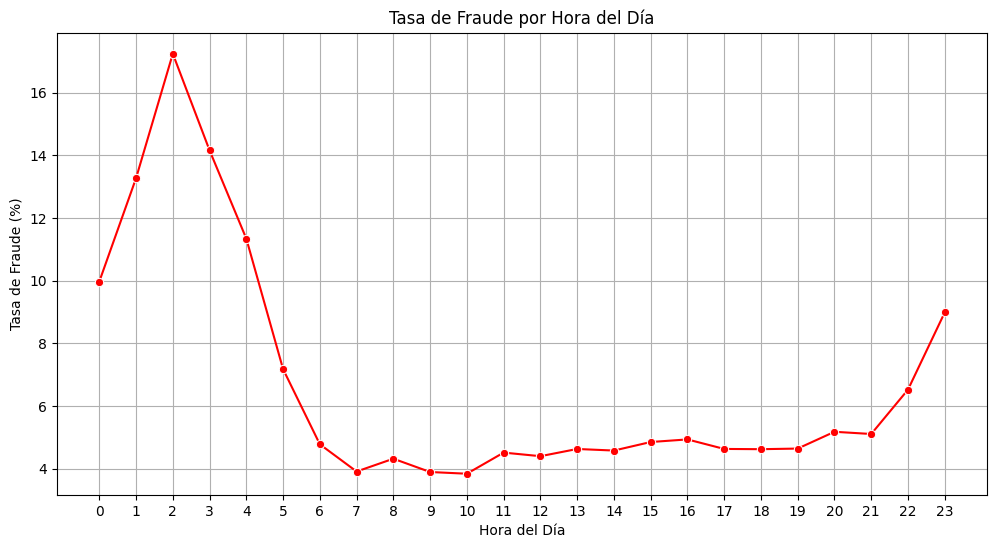

In [25]:
#Tasa de fraude por hora del día
fraud_rate_by_hour = data.groupby('hora')['fraude'].mean() * 100

plt.figure(figsize=(12, 6))
sns.lineplot(x=fraud_rate_by_hour.index, y=fraud_rate_by_hour.values, marker="o", color="red")
plt.xlabel("Hora del Día")
plt.ylabel("Tasa de Fraude (%)")
plt.title("Tasa de Fraude por Hora del Día")
plt.xticks(range(0, 24))
plt.grid(True)
plt.show()


Se puede ver que la tasa de fraude es muy superior en ciertas horas de la noche y la madrugada con respecto a otras horas. En ese orden de ideas usar nuestra variable de hora puede brindar información útil al modelo. Se construye una variable binaria indicando si el horario es de riesgo o no a partir de la variable hora.
La idea es usar esta y no directamente la variable hora, la razón es que al ser una variable numérica pero tener una connotación cíclica, puede llegar a confundir al algoritmo si no se le imprime una noción de ciclicidad, se podría hacer esto interpolando la hora con coseno y seno, pero para mantener las cosas simples se usa la variable binaria que indica si es horario de riesgo o no.

In [26]:
#Variable binaria de horario riesgoso.
high_risk_hours = [0, 1, 2, 3, 4, 22, 23]
data['high_risk_hour'] = data['hora'].isin(high_risk_hours).astype('category')

## VARIABLES NUMÉRICAS

In [27]:
#Estadísticos descriptivos de las variables numéricas originales
numeric_summary = df_original[numerical_features].describe().T

numeric_summary

,count,mean,std,min,25%,50%,75%,max
b,137016.0,0.728115,0.132943,0.000000,0.678400,0.755500,0.806500,1.000000e+00
c,137016.0,260445.107044,846436.141626,0.160000,9679.915000,43711.655000,145443.627500,1.387874e+07
d,149635.0,21.677669,20.062146,0.000000,2.000000,14.000000,50.000000,5.000000e+01
e,150000.0,0.220641,2.434995,0.000000,0.000000,0.104875,0.282938,8.333333e+02
f,149989.0,51.169352,709.472904,-5.000000,1.000000,8.000000,33.000000,1.452740e+05
h,150000.0,14.193513,14.161216,0.000000,3.000000,9.000000,21.000000,5.800000e+01
k,150000.0,0.497532,0.288348,0.000004,0.246819,0.495990,0.746508,9.999948e-01
l,149989.0,2305.409403,1712.379601,0.000000,910.000000,1937.000000,3445.000000,7.544000e+03
m,149635.0,299.969579,321.075806,0.000000,42.000000,193.000000,459.000000,2.225000e+03
monto,150000.0,43.523134,91.557888,0.020000,9.380000,20.610000,40.692500,3.696350e+03


- La variable 'b' y su concentración cercana a 1 con presencia de outliers cercanos a 0.
- La variable 'c' tiene presencia de valores muy extremos en su cota superior.
- La variable 'e' concentra la mayoría de su distribución antes de 1, no obstante hay un valor atípico de 833 (se tratará de un error?)
- La variable 'f' presenta tan solo un puñado de valores negativos (se tratará de un error?)

In [28]:
numeric_summary_list = []

for var in numerical_features:
    for fraude_status in [1, 0]:  
        stats_values = df_original[df_original["fraude"] == fraude_status][var].describe()
        numeric_summary_list.append({
            "Fraude": "Sí" if fraude_status == 1 else "No",
            "Variable": var,
            "count": stats_values["count"],
            "mean": stats_values["mean"],
            "std": stats_values["std"],
            "min": stats_values["min"],
            "25%": stats_values["25%"],
            "50%": stats_values["50%"],
            "75%": stats_values["75%"],
            "max": stats_values["max"]
        })

numeric_summary = pd.DataFrame(numeric_summary_list)
numeric_summary = numeric_summary.sort_values(by=["Variable", "Fraude"], ascending=[True, False])
numeric_summary

,Fraude,Variable,count,mean,std,min,25%,50%,75%,max
0,Sí,b,6671.0,0.750986,1.516348e-01,0.000000,0.701100,0.770400,0.830900,1.000000e+00
1,No,b,130345.0,0.726945,1.318090e-01,0.000000,0.677300,0.754800,0.805400,1.000000e+00
2,Sí,c,6671.0,384770.684747,1.089891e+06,1.140000,8678.410000,49068.520000,178246.620000,1.387874e+07
3,No,c,130345.0,254082.178440,8.315678e+05,0.160000,9739.920000,43479.520000,144148.040000,1.387565e+07
4,Sí,d,7471.0,14.868425,1.796173e+01,0.000000,1.000000,5.000000,24.000000,5.000000e+01
5,No,d,142164.0,22.035508,2.010285e+01,0.000000,3.000000,15.000000,50.000000,5.000000e+01
6,Sí,e,7500.0,0.196641,6.724671e-01,0.000000,0.000000,0.015522,0.248120,3.280000e+01
7,No,e,142500.0,0.221904,2.493479e+00,0.000000,0.000000,0.108192,0.284183,8.333333e+02
8,Sí,f,7500.0,18.733067,2.008885e+02,-4.000000,0.000000,1.000000,8.000000,1.092200e+04
9,No,f,142489.0,52.876657,7.264049e+02,-5.000000,2.000000,9.000000,34.000000,1.452740e+05


- Las variables:  'c', 'monto' y 'score' en promedio tienen un valor más alto para las transacciones fraude que las no fraude. Para monto tiene sentido, pues refleja el comportamiento del defraudador de sacar la mayor cantidad de beneficio posible en un intento. En Score también tendría sentido, suponiendo que se trata de un tipo de valoración de riesgo. 
- Las variables: 'f', 'l' y 'm' en promedio tienen un valor más bajo para las transacciones fraude que las no fraude.
- El resto de las variables también difiere en promedio sus valores teniendo en cuenta las diferentes poblaciones. No obstante, sus valores promedios no son tan diferentes.

Se realizará un análisis un poco más detallado para algunas de las variables, bien sea porque mostraron comportamientos inusuales en las secciones anteriores del EDA.

### VARIABLE C

Esta variable presentó una gran cantidad de outliers y una posible diferencia entre las transacciones fraude y no fraude

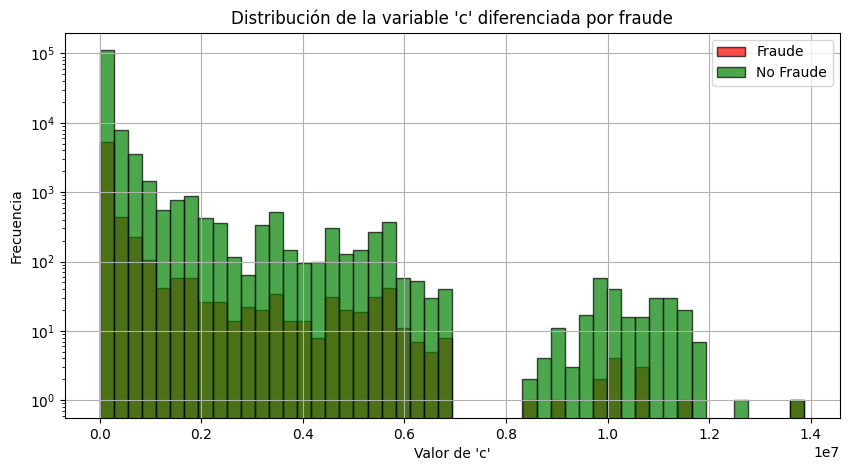

In [29]:
#Histograma variable 'c' por monto
plt.figure(figsize=(10, 5))
plt.hist(df_original[df_original["fraude"] == 1]["c"].dropna(), bins=50, color='red', alpha=0.7, edgecolor='black', label="Fraude")
plt.hist(df_original[df_original["fraude"] == 0]["c"].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black', label="No Fraude")
plt.title("Distribución de la variable 'c' diferenciada por fraude")
plt.xlabel("Valor de 'c'")
plt.ylabel("Frecuencia")
#Escala logarítmica en Y para mejorar la visualización
plt.yscale('log')  
plt.legend()
plt.grid(True)
plt.show()

In [30]:
c_fraud_analysis = df_original.groupby("fraude")["c"].describe()
c_fraud_analysis

,count,mean,std,min,25%,50%,75%,max
fraude,,,,,,,,
0,130345.0,254082.178440,8.315678e+05,0.16,9739.92,43479.52,144148.04,13875647.01
1,6671.0,384770.684747,1.089891e+06,1.14,8678.41,49068.52,178246.62,13878743.71


Cuando se comparan amba poblacions de fraude y no fraude en la variable 'c', podemos ver que si existen diferencias, pues los valores fraude tienden a ser más altos

In [31]:
bins_c = pd.qcut(df_original["c"], q=10, duplicates="drop")
fraud_rate_c = df_original.groupby(bins_c)["fraude"].mean() * 100
fraud_rate_c_df = fraud_rate_c.to_frame().rename(columns={"fraude": "Tasa de Fraude (%)"})
fraud_rate_c_df

,Tasa de Fraude (%)
c,
"(0.159, 1800.125]",6.707050
"(1800.125, 6285.86]",4.079696
"(6285.86, 13878.475]",4.116488
"(13878.475, 26123.49]",4.079696
"(26123.49, 43711.655]",4.262463
"(43711.655, 70814.5]",4.400817
"(70814.5, 112449.235]",4.612802
"(112449.235, 191395.0]",4.736535
"(191395.0, 454000.63]",4.766075


Si dividimos la variable en bins, vemso que la tasa de fraude si es superior en lso ultimso bins (valores más altos de la variable 'c'.

### VARIABLE F

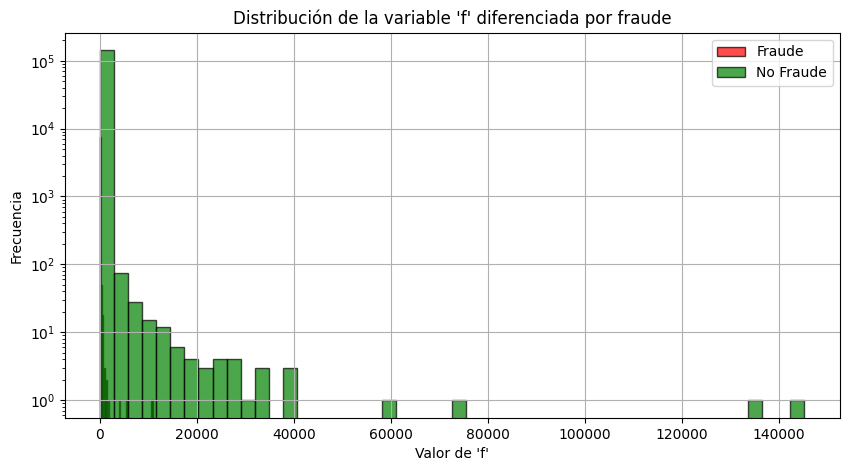

In [32]:
#Histograma variable 'f' diferenciado por 'fraude'
plt.figure(figsize=(10, 5))
plt.hist(df_original[df_original["fraude"] == 1]["f"].dropna(), bins=50, color='red', alpha=0.7, edgecolor='black', label="Fraude")
plt.hist(df_original[df_original["fraude"] == 0]["f"].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black', label="No Fraude")
plt.title("Distribución de la variable 'f' diferenciada por fraude")
plt.xlabel("Valor de 'f'")
plt.ylabel("Frecuencia")
#Escala logarítmica en Y para mejorar la visualización
plt.yscale('log')  
plt.legend()
plt.grid(True)
plt.show()

Esta variable muestra un comportamiento en el cual las transacciones de fraude se concentran en los valores bajos.

In [33]:
f_fraud_analysis = df_original.groupby("fraude")["f"].describe()
f_fraud_analysis

,count,mean,std,min,25%,50%,75%,max
fraude,,,,,,,,
0,142489.0,52.876657,726.404869,-5.0,2.0,9.0,34.0,145274.0
1,7500.0,18.733067,200.888521,-4.0,0.0,1.0,8.0,10922.0


La tasa de fraude aumenta, pero hasta valores muy pequeños de la variable, comparadao con los valores más altos alcanzados por las tranacciones no fraude.

In [34]:
bins_f = pd.qcut(df_original["f"], q=10, duplicates="drop")
fraud_rate_f = df_original.groupby(bins_f)["fraude"].mean() * 100
fraud_rate_f_df = fraud_rate_f.to_frame().rename(columns={"fraude": "Tasa de Fraude (%)"})
fraud_rate_f_df.head(20)

,Tasa de Fraude (%)
f,
"(-5.001, 0.0]",11.369858
"(0.0, 1.0]",6.712329
"(1.0, 2.0]",5.563282
"(2.0, 4.0]",5.090352
"(4.0, 8.0]",4.244049
"(8.0, 14.0]",3.743241
"(14.0, 25.0]",2.715134
"(25.0, 44.0]",2.430387
"(44.0, 92.0]",1.859616


### VARIABLE MONTO

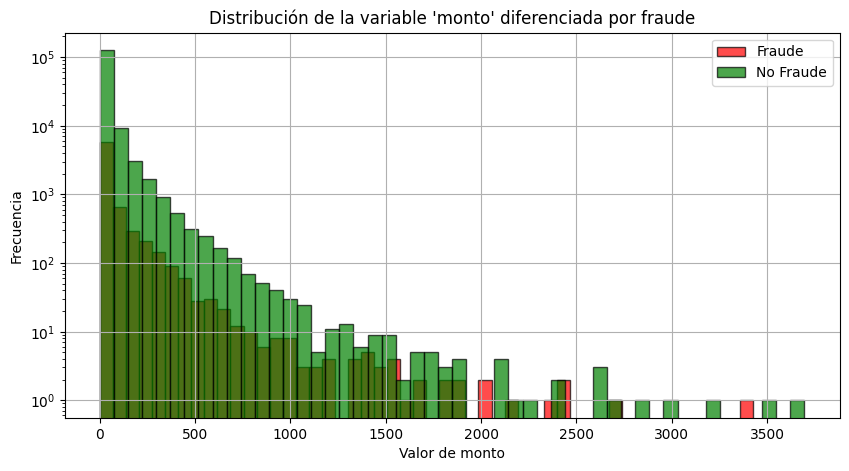

In [35]:
#Histograma variable 'monto' diferenciado por 'fraude'
plt.figure(figsize=(10, 5))
plt.hist(df_original[df_original["fraude"] == 1]["monto"].dropna(), bins=50, color='red', alpha=0.7, edgecolor='black', label="Fraude")
plt.hist(df_original[df_original["fraude"] == 0]["monto"].dropna(), bins=50, color='green', alpha=0.7, edgecolor='black', label="No Fraude")
plt.title("Distribución de la variable 'monto' diferenciada por fraude")
plt.xlabel("Valor de monto")
plt.ylabel("Frecuencia")
#Escala logarítmica en Y para mejorar la visualización
plt.yscale('log')  
plt.legend()
plt.grid(True)
plt.show()

In [36]:
monto_fraud_analysis = df_original.groupby("fraude")["monto"].describe()
monto_fraud_analysis

,count,mean,std,min,25%,50%,75%,max
fraude,,,,,,,,
0,142500.0,41.973326,85.708924,0.02,9.30,20.18,40.0225,3696.35
1,7500.0,72.969483,164.843328,0.21,10.82,25.87,59.0575,3424.81


Al igual que con la variable 'c' el 'monto' tiende a tener valores más altos

Al distribuir la variable 'monto' en bins y calcular su tasa de fraude vemso que es creciente, es decir, que aumneta la probabilidad de que una transacción se fraude con montos más altos.

In [37]:
bins_monto = pd.qcut(df_original["monto"], q=10, duplicates="drop")
fraud_rate_monto = df_original.groupby(bins_monto)["fraude"].mean() * 100
fraud_rate_monto_df = fraud_rate_monto.to_frame().rename(columns={"fraude": "Tasa de Fraude (%)"})
fraud_rate_monto_df

,Tasa de Fraude (%)
monto,
"(0.019, 5.35]",3.118960
"(5.35, 7.83]",4.924469
"(7.83, 10.91]",4.570933
"(10.91, 14.76]",3.966777
"(14.76, 20.61]",4.664704
"(20.61, 26.84]",4.408724
"(26.84, 35.083]",5.107688
"(35.083, 48.95]",4.626358
"(48.95, 86.652]",5.727048


### VARIABLE SCORE

In [38]:
stats_score = df_original.groupby('fraude')['score'].describe()

#Tasa de fraude en diferentes rangos de score
df_original['score_bin'] = pd.qcut(df_original['score'], q=10, duplicates='drop')

tasa_fraude_por_score = df_original.groupby('score_bin')['fraude'].mean() * 100
tasa_fraude_por_score

score_bin
(-0.001, 8.0]     2.777251
(8.0, 18.0]       4.714591
(18.0, 28.0]      3.063545
(28.0, 38.0]      0.333378
(38.0, 48.0]      0.629431
(48.0, 58.0]      1.305658
(58.0, 68.0]      2.137435
(68.0, 78.0]      5.318578
(78.0, 88.0]      8.894789
(88.0, 100.0]    21.802080
Name: fraude, dtype: float64

La tasa de fraude es crecienet a medida que esta aumenta, lo que indica que muy posiblemente este score este relacionado con el riesgo de la transacción. Esta variable se empleará en el modelo

### TEST NORMALIDAD KS

In [39]:
normality_results = []
for column in numerical_features:
    for fraude_status in [1, 0]: 
        group = df_original[df_original['fraude'] == fraude_status][column].dropna()
        stat, p_value = kstest(group, 'norm')

        normality_results.append({
            "Fraude": "Sí" if fraude_status == 1 else "No",
            "Variable": column,
            "KS Statistic": stat,
            "p-value": p_value,
            "Normalidad": "Sí" if p_value > 0.05 else "No"
        })

normality_df = pd.DataFrame(normality_results)
normality_df = normality_df.sort_values(by=["Variable", "Fraude"], ascending=[True, False])
normality_df

,Fraude,Variable,KS Statistic,p-value,Normalidad
0,Sí,b,0.639329,0.0,No
1,No,b,0.638856,0.0,No
2,Sí,c,0.999328,0.0,No
3,No,c,0.999294,0.0,No
4,Sí,d,0.819929,0.0,No
5,No,d,0.836941,0.0,No
6,Sí,e,0.500000,0.0,No
7,No,e,0.500000,0.0,No
8,Sí,f,0.485067,0.0,No
9,No,f,0.730129,0.0,No


Se aplica el test Ks de normalidad para evaluar si las distribuciones de las variables numéricas diferenciadas pro fraude o no fraude siguen una distribución normal.
Se concluye que ninguna lo hace. Esto será útil a la hora de emplear test de relación entre las variables y la variable objetivo, pues no cumpliendose el supuesto de normalidad por ejemplo no podemos evaluar la relación entre estos usando un test de Anova, se tendría que usar Mann-Whitney U.

### DISTRIBUCIONES DE LAS VARIABLES NUMÉRICAS DIFERENCIADAS POR FRAUDE

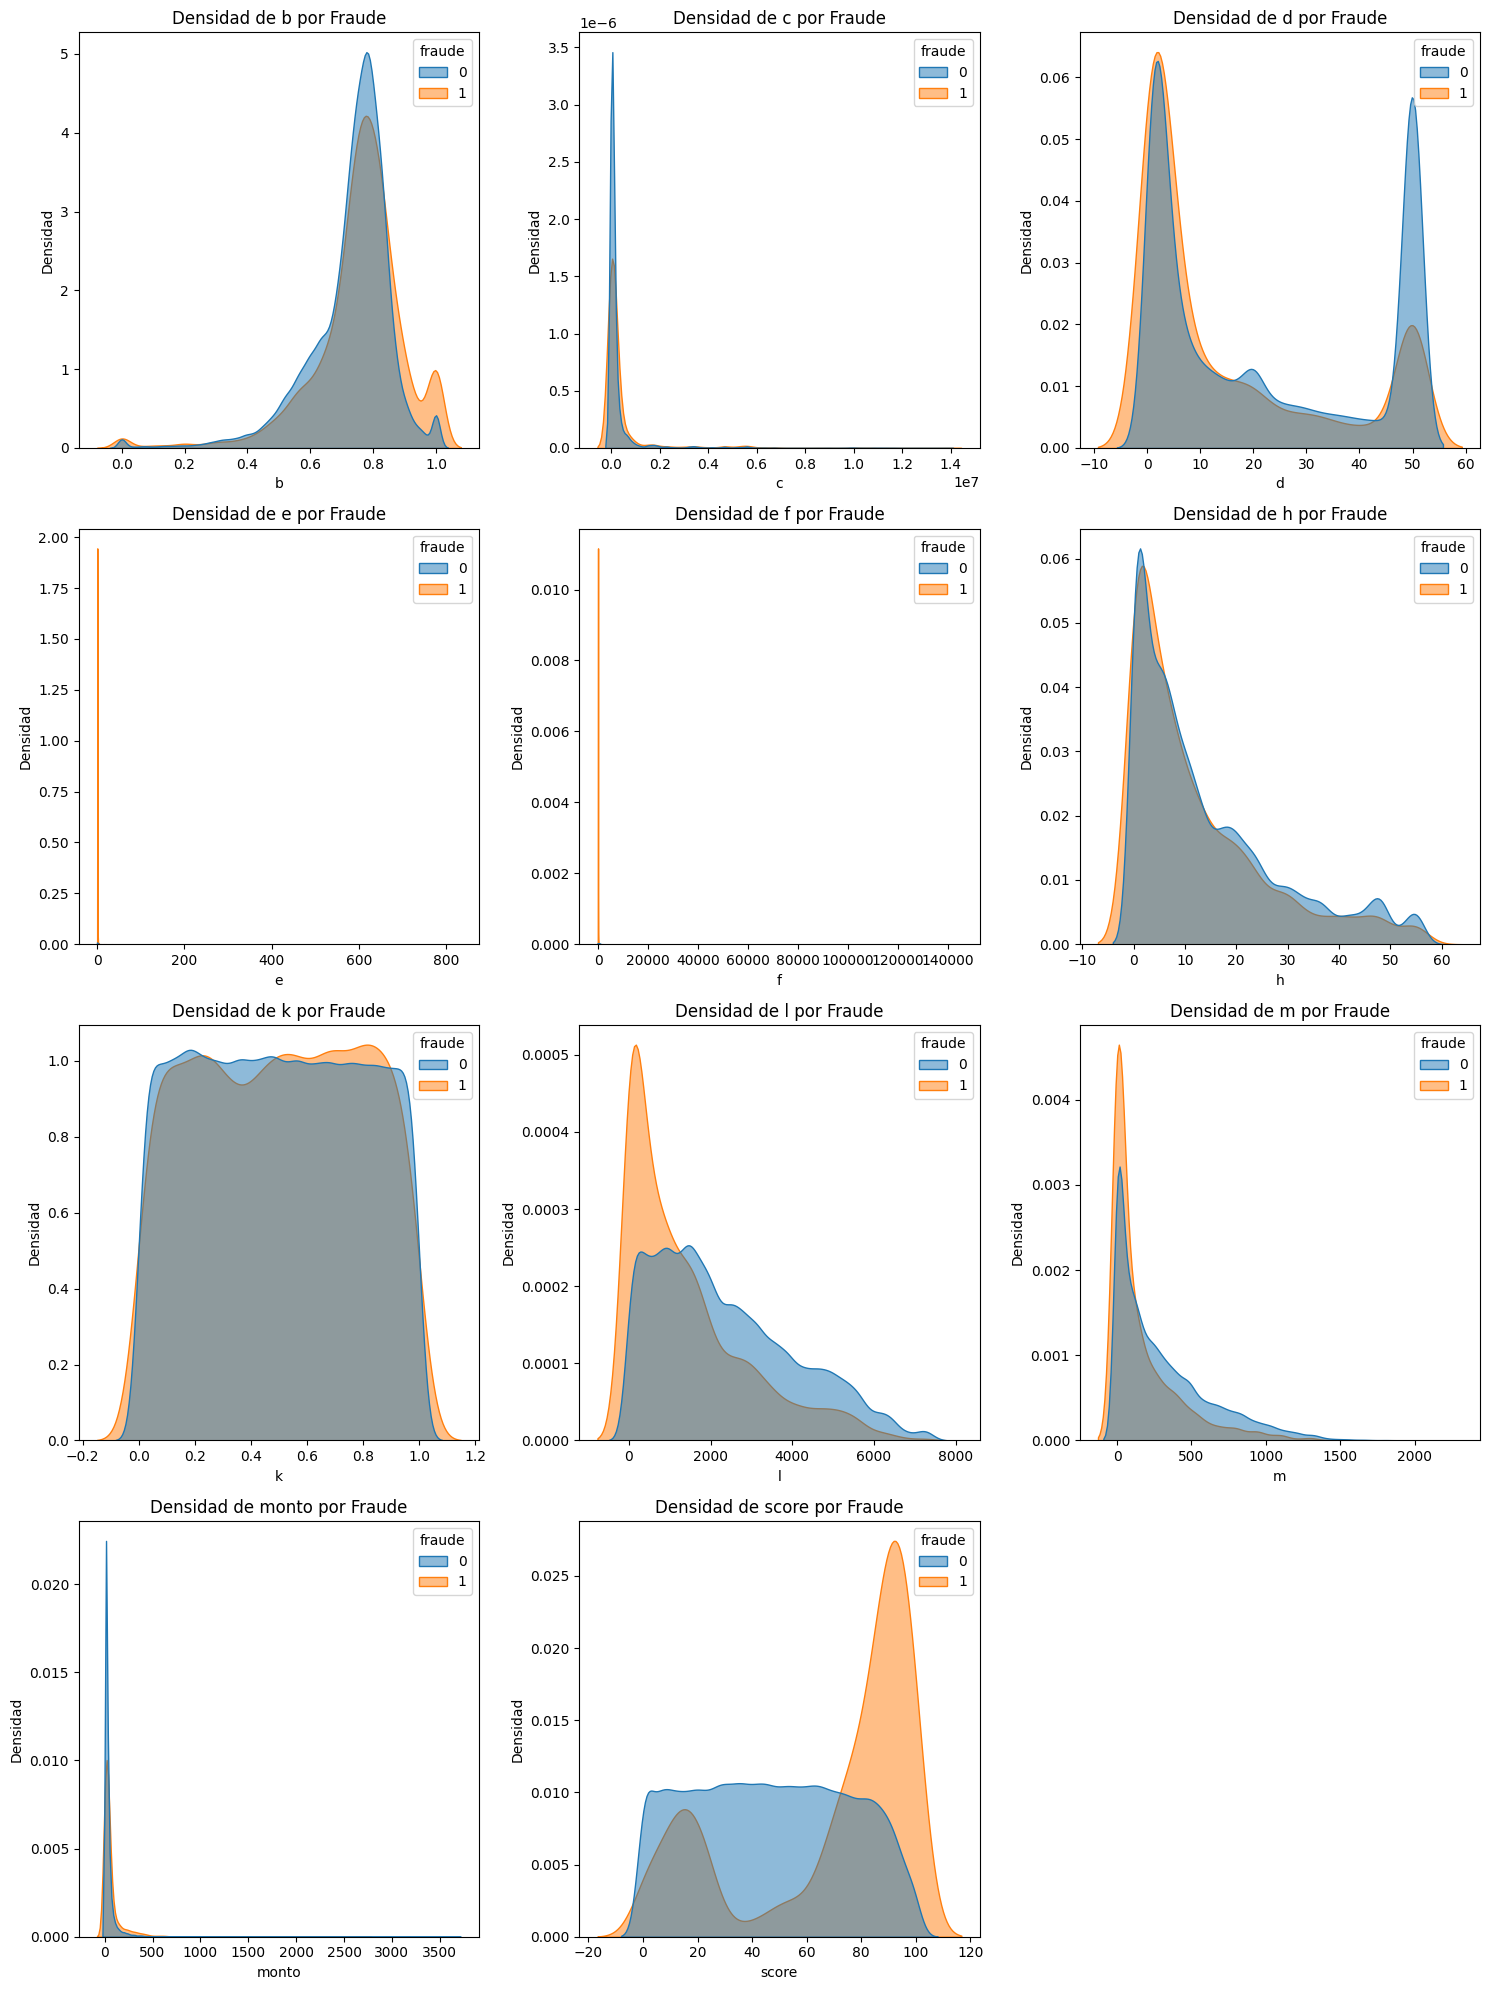

In [40]:
#Filtro valores nulos del dataframe para poder graficar densidad
data_filtered = df_original[numerical_features].dropna()
fraude=df_original['fraude']

num_vars = len(numerical_features)
num_cols = 3  
num_rows = int(np.ceil(num_vars / num_cols))  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  

for i, column in enumerate(numerical_features):
    sns.kdeplot(data=data_filtered, x=column, hue=fraude, common_norm=False, fill=True, alpha=0.5, ax=axes[i])
    axes[i].set_title(f'Densidad de {column} por Fraude')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Densidad')

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

Se puede corroborar visualmente lo hast aahora encontrado. 
Ninguna de las variable sigue una distribución normal.
Enalgunas de las variables existen patrones diferenciadores entre la población fraude y no fraude, como se puede apreciar en las vaiables : 'score', 'l' y 'm'

### BOXPLOTS

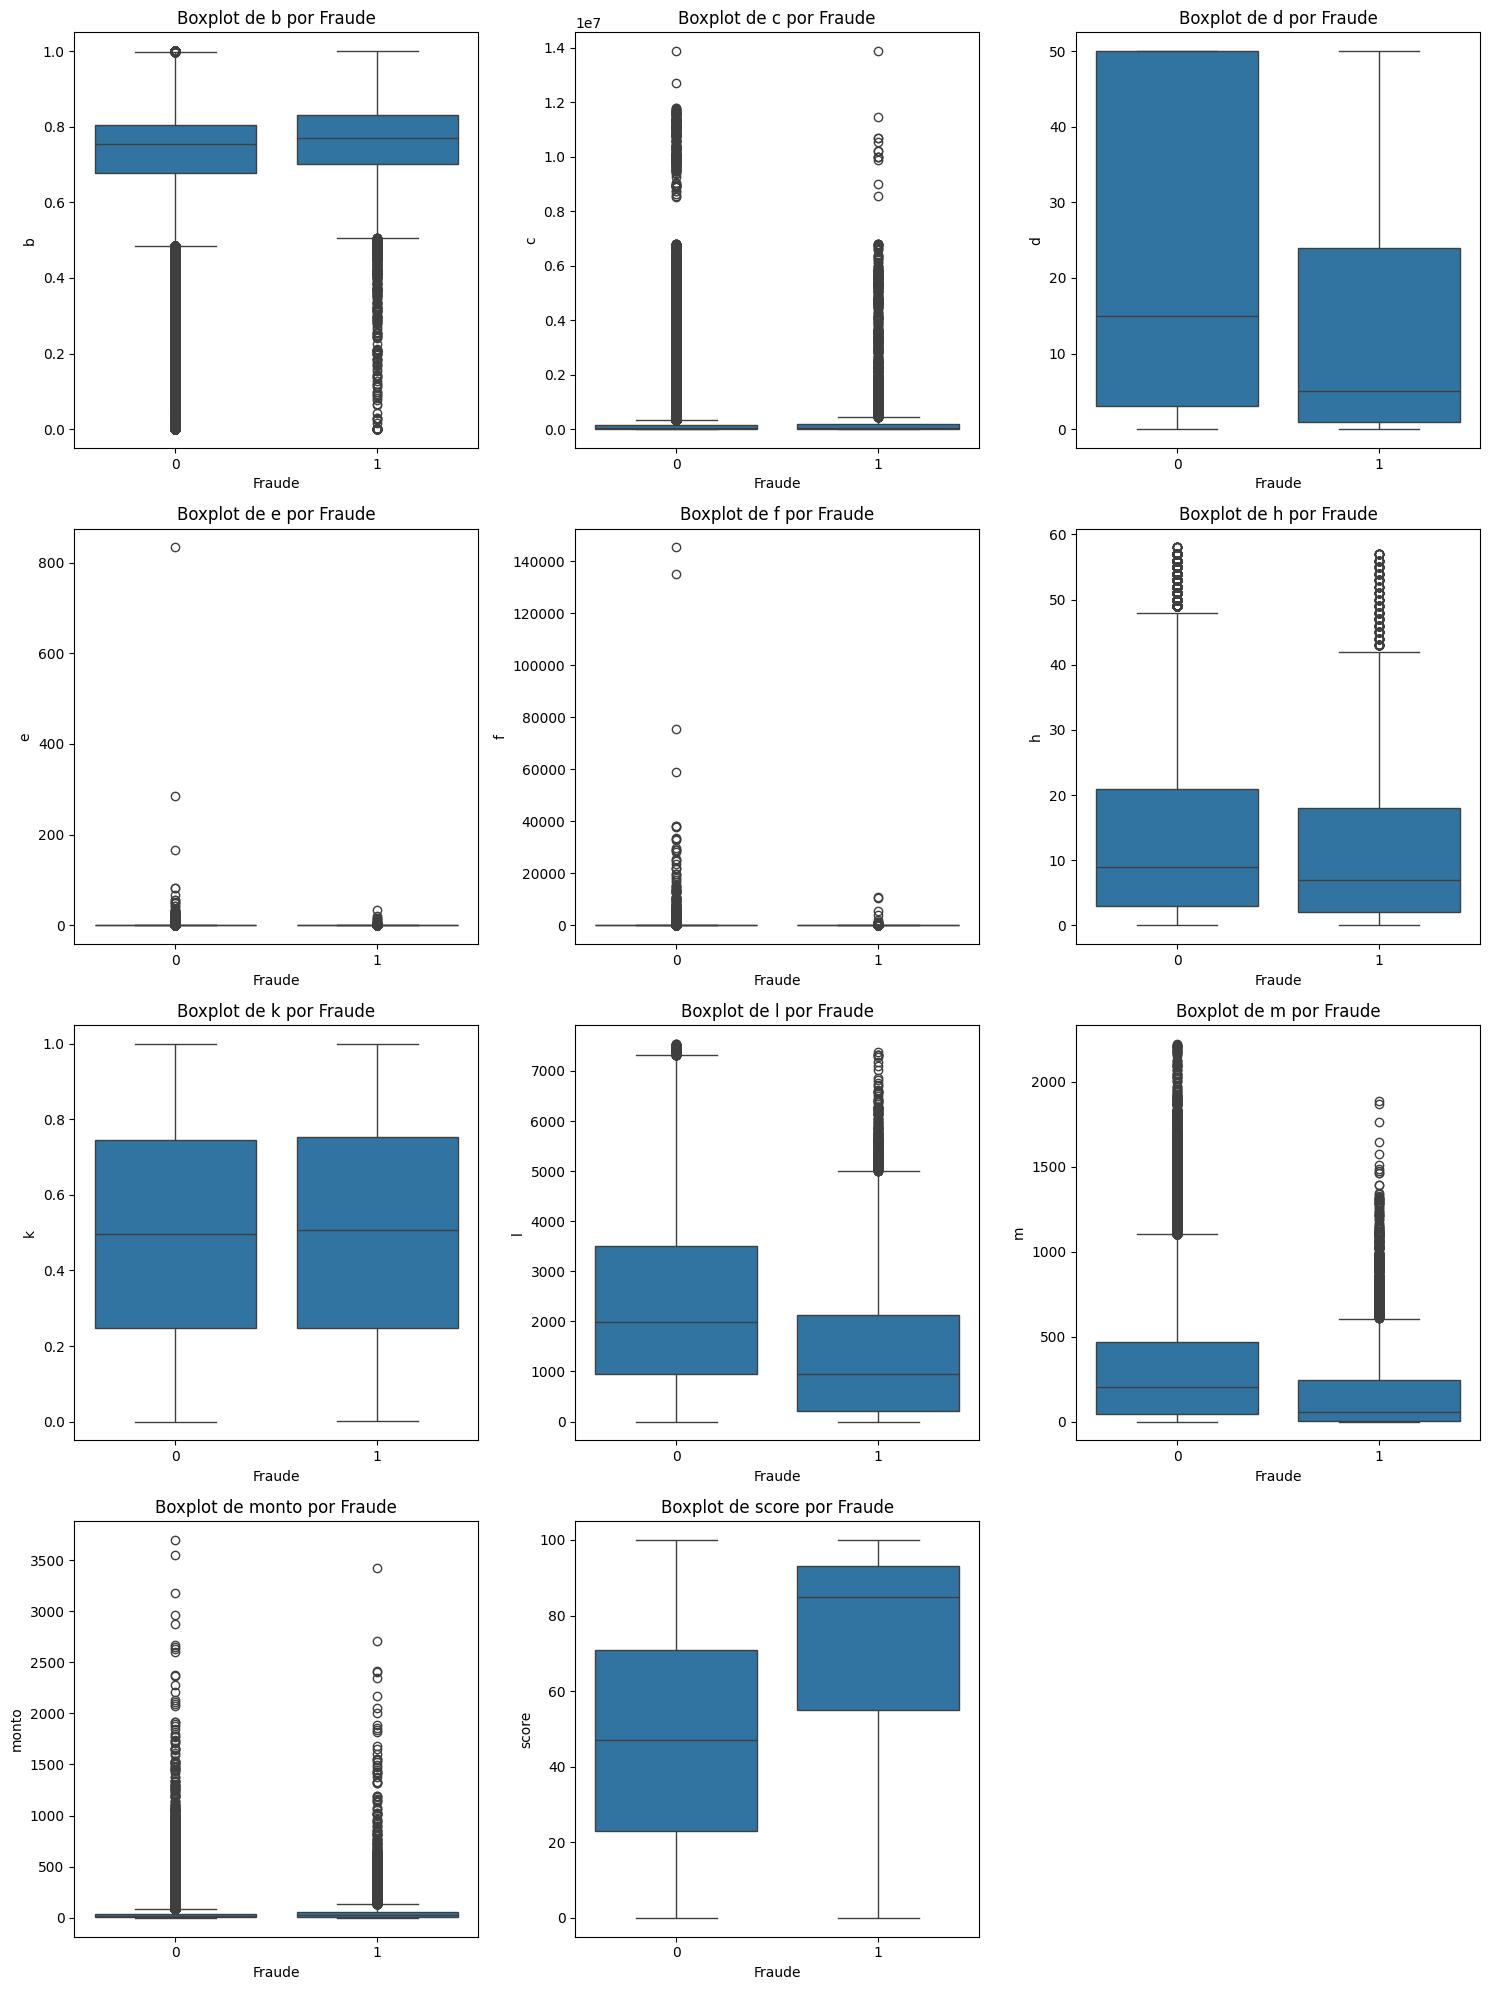

In [41]:
num_cols =3
num_rows = int(np.ceil(len(numerical_features) / num_cols))  

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, num_rows * 5))
axes = axes.flatten()  

for i, column in enumerate(numerical_features):
    sns.boxplot(data=df_original, x='fraude', y=column, ax=axes[i])
    axes[i].set_title(f'Boxplot de {column} por Fraude')
    axes[i].set_xlabel('Fraude')
    axes[i].set_ylabel(column)

for j in range(i + 1, len(axes)):
    axes[j].set_axis_off()

plt.tight_layout()
plt.show()

Se evidencia nuevamenete el problema de outliers en algunas de las variables. De igual forma se puede ver más claramente las diferencias entre fraude y no fraude en algunas de las variables: 'd', 'l', 'm', 'score'

### CORRELACIÓN DE PEARSON

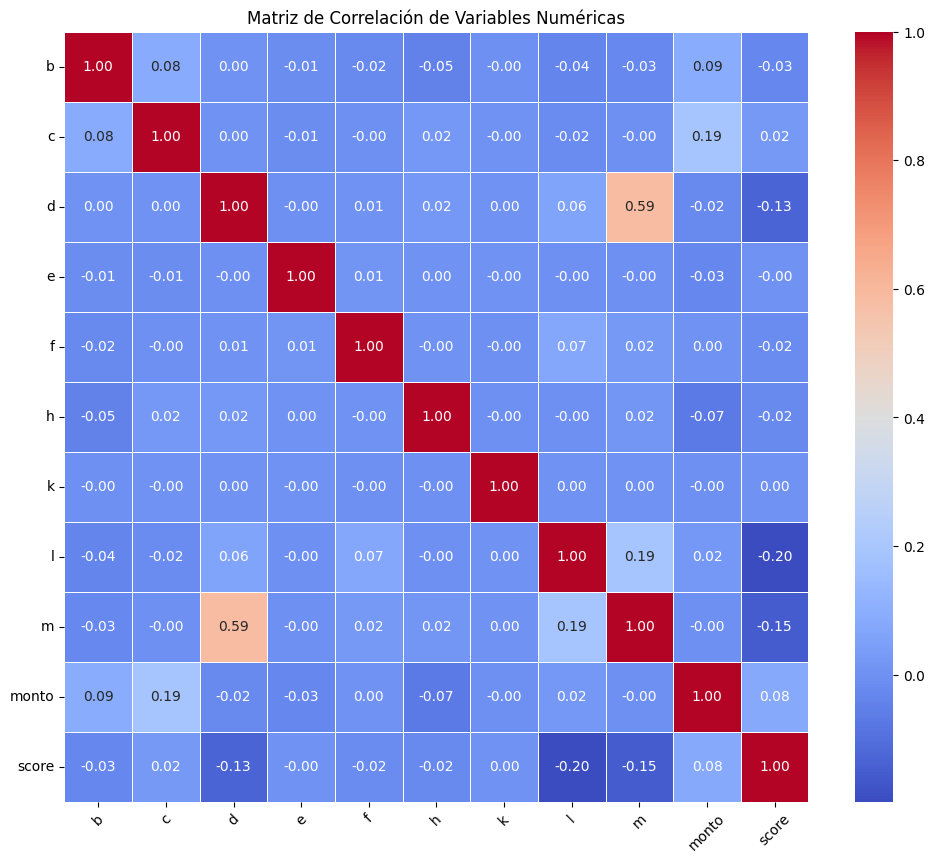

In [42]:
#Matriz de correlación
correlation_matrix = df_original[numerical_features].corr()

plt.figure(figsize=(12, 10))
ax = sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)

plt.yticks(rotation=0)
plt.xticks(rotation=45)

plt.title('Matriz de Correlación de Variables Numéricas')

plt.show()

No se evidencian casos de correlación lineal perfecta o multicolinealidad. Hay correlciones fuertes entre las variables 'm' y 'd'.

### CORRELACIÓN BISERIAL

   Variable  Correlación Biserial Puntual
0     score                      0.167735
1     monto                      0.074626
2         b                      0.038775
3         c                      0.033109
4         k                      0.002584
5         e                     -0.001875
6         f                     -0.010325
7         h                     -0.030401
8         d                     -0.075974
9         m                     -0.091835
10        l                     -0.117901


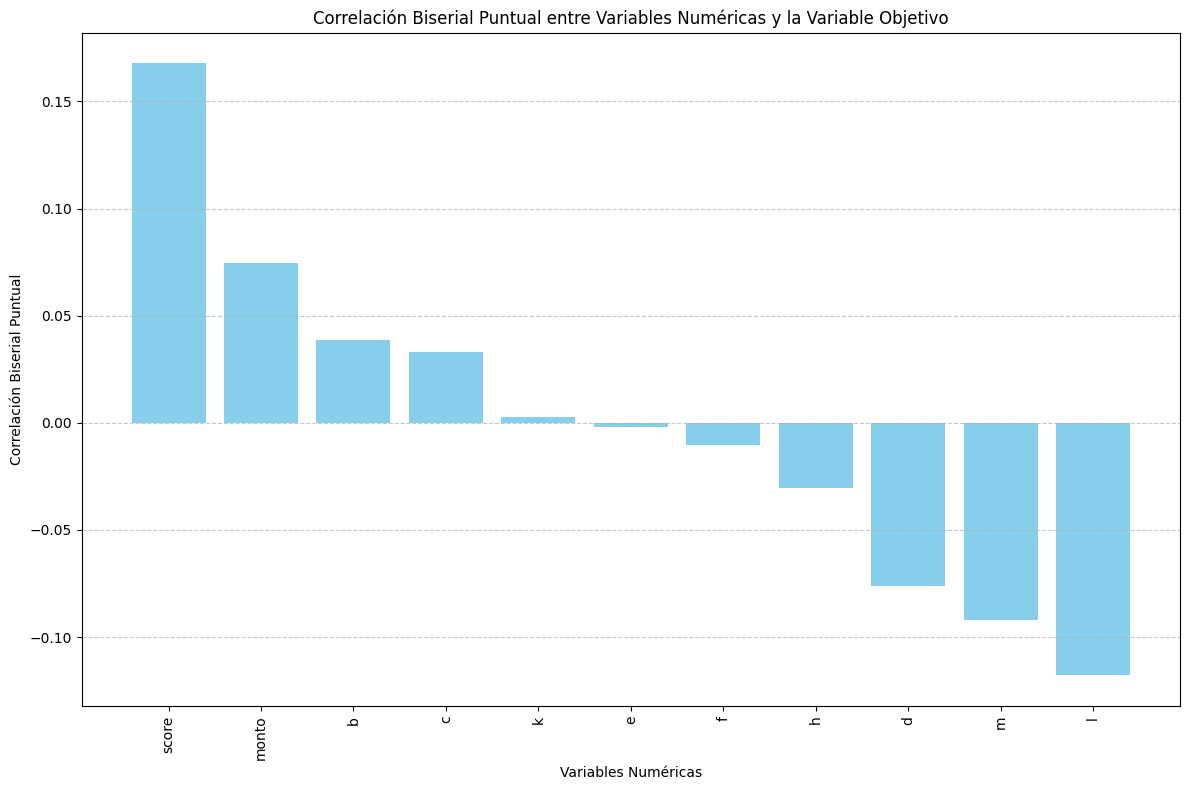

In [43]:
data_filtered['fraude'] = df_original['fraude'].dropna().astype(int)

numeric_data = data_filtered[numerical_features].dropna()

correlations = []

#Correlación biserial entre columnas numéricas y variable objetivo
for column in numeric_data.columns:
    corr, _ = pointbiserialr(numeric_data[column], data_filtered.loc[numeric_data.index, 'fraude'])
    correlations.append((column, corr))

correlation_data = pd.DataFrame(correlations, columns=['Variable', 'Correlación Biserial Puntual']).sort_values(
    by='Correlación Biserial Puntual', ascending=False).reset_index(drop=True)

print(correlation_data)
plt.figure(figsize=(12, 8))
plt.bar(correlation_data['Variable'], correlation_data['Correlación Biserial Puntual'], color='skyblue')
plt.xlabel('Variables Numéricas')
plt.ylabel('Correlación Biserial Puntual')
plt.title('Correlación Biserial Puntual entre Variables Numéricas y la Variable Objetivo')
plt.xticks(rotation=90)
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Podemos observar como y en que magnitud se correlacionan las variables independientes numéricas con la variable objetivo. Se corroboran insights ya encontrados como una posible correlación positiva con fraude y las variables 'score', 'monto', 'b' y 'c'. Y negativa con 'l', 'm' y 'd'
si bien los valores de la correlación no son muy altos, es de utilidad corroborar las hipótesis que se han creado a o largo del EDA

### MANN - WHITNEY U

Dado que las variables no se distribuyen normalmente, no se puede emplear un test de Anova. No obstante si podemos aplicar est etest para ver si existen diferencias entre las poblaciones de fraude y no fraude para cada variable numérica.

In [44]:
mannwhitney_results = []

#Prueba de Mann-Whitney U
for column in numerical_features:
    group1 = data_filtered[data_filtered['fraude'] == 1][column].dropna()
    group0 = data_filtered[data_filtered['fraude'] == 0][column].dropna()

    if len(group1) > 0 and len(group0) > 0:
        stat, p_value = mannwhitneyu(group1, group0, alternative='two-sided')
        significance = "Sí" if p_value < 0.05 else "No"
        mannwhitney_results.append((column, stat, p_value, significance))

mannwhitney_data = pd.DataFrame(mannwhitney_results, columns=[
    'Variable', 'Mann-Whitney U', 'p-valor', 'Diferencia Significativa'])

mannwhitney_data = mannwhitney_data.sort_values(by='p-valor').reset_index(drop=True)
mannwhitney_data

,Variable,Mann-Whitney U,p-valor,Diferencia Significativa
0,f,272632768.5,0.000000e+00,Sí
1,l,277238312.0,0.000000e+00,Sí
2,m,296930118.5,0.000000e+00,Sí
3,score,623434414.5,0.000000e+00,Sí
4,d,334360542.0,2.281598e-218,Sí
5,monto,492861714.0,3.352633e-83,Sí
6,b,486153444.0,3.344082e-66,Sí
7,h,389849371.0,1.256478e-41,Sí
8,e,404677933.0,6.083526e-20,Sí
9,c,441762115.5,2.362533e-03,Sí


El test confirma que para todas las variables numéricas excepto la variable 'k' existen diferencias estadísticamente significativas entre las poblaciones de transacciones fraude y no fraude.
Este hallazgo nos indicaría que tal vez incluir la variable 'k' no sea relevante para el ejercicio de aprendizaje de máquinas.

## VARIABLES CATEGÓRICAS

In [45]:
df_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 20 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   a          150000 non-null  category      
 1   b          137016 non-null  float64       
 2   c          137016 non-null  float64       
 3   d          149635 non-null  float64       
 4   e          150000 non-null  float64       
 5   f          149989 non-null  float64       
 6   g          149806 non-null  category      
 7   h          150000 non-null  int64         
 8   j          150000 non-null  category      
 9   k          150000 non-null  float64       
 10  l          149989 non-null  float64       
 11  m          149635 non-null  float64       
 12  n          150000 non-null  category      
 13  o          41143 non-null   category      
 14  p          150000 non-null  category      
 15  fecha      150000 non-null  datetime64[ns]
 16  monto      150000 no

In [46]:
categorical_summary = pd.DataFrame({
    'Variable': categorical_features,
    'Cantidad de categorías': [data[col].nunique() for col in categorical_features]
}).sort_values(by='Cantidad de categorías', ascending=False).reset_index(drop=True)

categorical_summary

,Variable,Cantidad de categorías
0,j,8324
1,g,51
2,a,4
3,n,2
4,o,2
5,p,2


Lo primero que resalta es la gran cantidad de categorias que tienen tanto la variable 'j' como la variable 'g'. Estas variables contienen valores que permiten hacerse una idea de que son.
Por un lado la variable 'j' pareciera contener información sobre referencias de productos. Por el otro lado, la columna 'g' contiene lso prefijos en iso 3166 de los países. Entre los valores de esta, se encontraron países inusuales como Taiwan, Rusia, etc. Siguiendo el prefacio del ejercicio se supone que esta data es de MercadoLibre, razón pro la cual se descarta que estos datos correspondan a datos de operación del comercio. Suponiendo entonces que se trata del país de la tarjeta. 
La variable 'a', parece ser una variable ordinal.

Con respecto a las variables categóricas de alta cardinalidad, es impensable introducirlas así al modelo. Por un lado, la numerización de estas, por ejemplo usando OHE llevaría a crecer exponencialmente la cantidad de features, aumentando drásticamente la complejidad del modelo, exigiendo así una mayor cantidad de datos y haciendo posible el escenario de la maldición de la dimensionalidad. Por tal motivo, se debe analizar estas variables frente a su relación con la variable objetivo para proponer una manera de poderlas introducir.



### VARIABLE A

In [47]:
a_counts = df_original['a'].value_counts()

distribucion_a = pd.DataFrame({
    'conteo': a_counts,
    'porcentaje': (a_counts / len(df_original)) * 100
})

#Tasa de fraude por cada valor de 'a'
fraude_por_a = df_original.groupby('a')['fraude'].mean() * 100

distribucion_a['tasa_fraude'] = fraude_por_a

distribucion_a

,conteo,porcentaje,tasa_fraude
a,,,
4,128579,85.719333,4.455627
2,14378,9.585333,7.775769
1,4195,2.796667,9.415971
3,2848,1.898667,9.058989


La variable 'a' parece ser ordinal, la mayoría de sus valores se concentran en el valor '4'. No obstante a pesar de esto, a tasa de fraude de este valor es relativamente baja comparada con los otros valores de la variable (1,2,3) los cuales tienen menos del 10% de la distribución de la variable (cada uno) y sus tasas de fraude son superiores a los del valor '4'.

In [48]:
#Tabla de contingencia entre 'a' y 'fraude'
tabla_contingencia = pd.crosstab(df_original['a'], df_original['fraude'])

#Prueba Chi cuadrado
chi2, p, dof, expected = stats.chi2_contingency(tabla_contingencia)

df_chi2_a = pd.DataFrame({
    "Métrica": ["Chi2", "p-valor", "Grados de libertad"],
    "Valor": [chi2, p, dof]
})

df_chi2_a

,Métrica,Valor
0,Chi2,5.844466e+02
1,p-valor,2.371873e-126
2,Grados de libertad,3.000000e+00


La prueba chi cuadrado entre esta variable y fraude nos dice que si existe una relación entre ambas.

### VARIABLE G

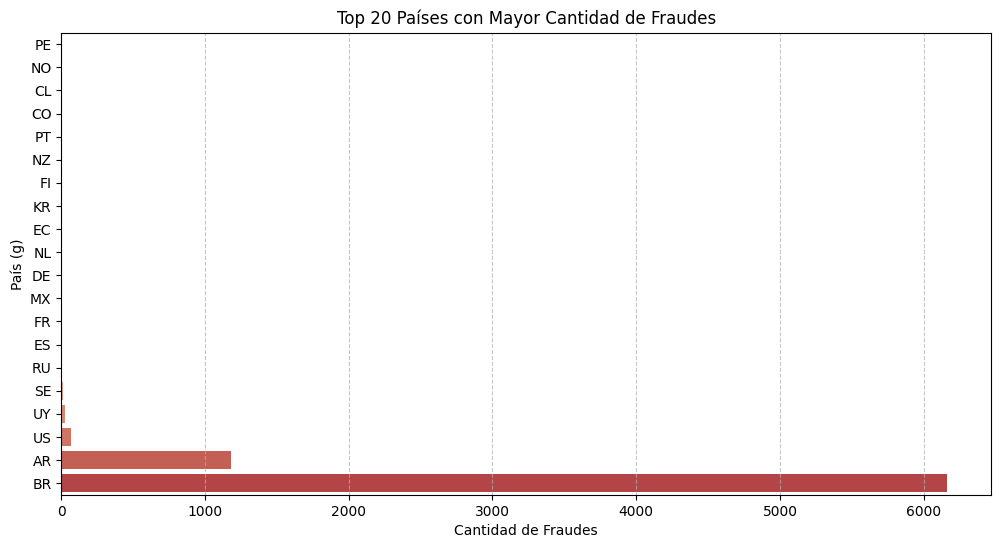

In [49]:
#Número total de fraudes por país
fraud_counts_by_country = df_original[df_original['fraude'] == 1]['g'].value_counts().reset_index()
fraud_counts_by_country.columns = ['País', 'Cantidad de Fraudes']

#Top 20 países con más fraudes
top_fraud_countries = fraud_counts_by_country.nlargest(20, 'Cantidad de Fraudes')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_fraud_countries, x='Cantidad de Fraudes', y='País', palette='coolwarm',
           order=top_fraud_countries.sort_values('Cantidad de Fraudes', ascending=True)['País'])
plt.xlabel("Cantidad de Fraudes")
plt.ylabel("País (g)")
plt.title("Top 20 Países con Mayor Cantidad de Fraudes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

El top 5 de los paises de las tarjetas de credito que mayor cantidad de fraudes concentran son BR, AR, US, UY y SE (Suecia).
si bien ne jumeros totales el top 2 de paises es el que tiene mayor cantidad de fraude, también son lso qu emayor cantidad de transacciones tienen. En otras palabras, su tasa de fraude no necesariamente será igual de alta.

In [50]:
#Tasa de fraude por país de tarjeta
fraud_rate_by_g = df_original.groupby('g')['fraude'].mean().sort_values(ascending=False).reset_index()

#Total de transacciones por país
transaction_count_by_g = df_original['g'].value_counts().reset_index()
transaction_count_by_g.columns = ['g', 'Total Transacciones']

fraud_analysis_g = fraud_rate_by_g.merge(transaction_count_by_g, on='g')

#Filtro de países con al menos X(20) transacciones para evitar ruido
min_transactions = 20
filtered_fraud_analysis_g = fraud_analysis_g[fraud_analysis_g['Total Transacciones'] >= min_transactions]

filtered_fraud_analysis_g = filtered_fraud_analysis_g.sort_values(by='fraude', ascending=False)

filtered_fraud_analysis_g

,g,fraude,Total Transacciones
8,RU,0.082192,73
10,ES,0.072464,69
11,BR,0.055201,111628
12,SE,0.041899,358
13,AR,0.036885,31964
14,US,0.030796,2273
15,CO,0.015625,64
16,MX,0.012712,236
17,UY,0.009774,2967
43,GB,0.000000,43


Arbitrariamente se filtraron los países de tarjeta que tuvieran menso de X (20) transacciones. La razón es para evitar una sobre estimación del problema, pus pueden haber países con un fraude y una sola transacción, teniendo así una tasa de fraude del 100%. Al ver esta tabla, vemos como Rusia (país inusual para compras en Latam) se convierte en el más riesgoso. Seguido de España, seguido de Brasil y luego Suecia. Dado que la diferencia en las tasas de fraude noes tan marcada entre países, se usará un target encoding para crear una nueva variable numérica que seria la tasa de fraude para cada país. Esto con el ánimo de evitar usar la variable en su formato categórico y asumiendo los retos que esto conlleva.

In [51]:
#Se calcula la tasa de fraude por país para hacer el target encoding
fraud_rate_per_country = df_original.groupby('g')['fraude'].mean()

#Se mapea la tasa de fraude a cada transacción dado el país.
data['g_encoded'] = data['g'].map(fraud_rate_per_country)

#Resultado
g_encoded_summary = data['g_encoded'].describe()
g_encoded_summary

count    149806.000000
mean          0.049965
std           0.011741
min           0.000000
25%           0.036885
50%           0.055201
75%           0.055201
max           1.000000
Name: g_encoded, dtype: float64

Esta nueva variable al ser la tasa de fraude se encontrará entre 0 y 1 asignando riesgo a cada país.

### VARIABLE J

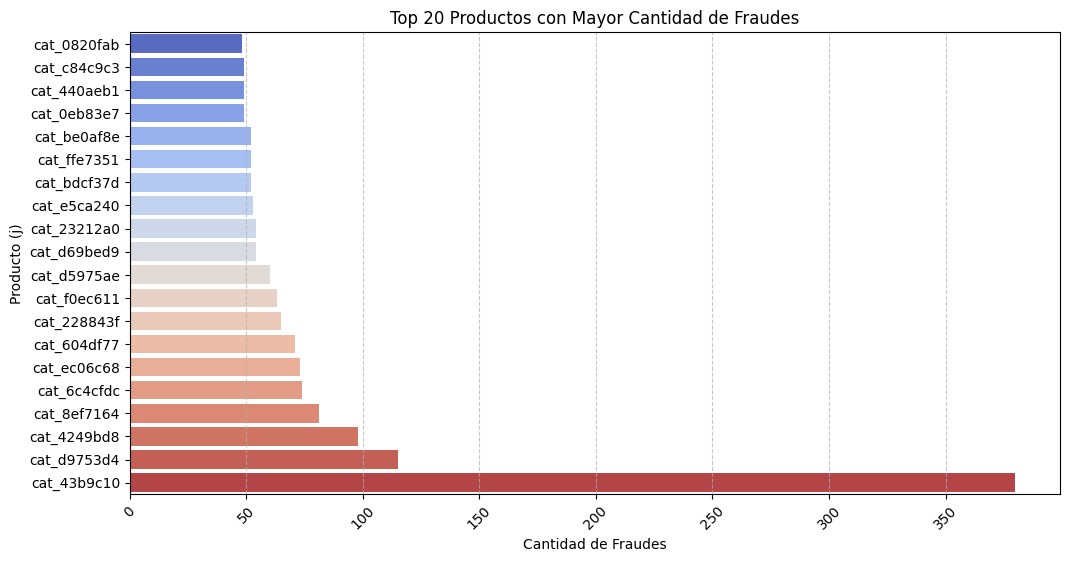

In [52]:
#Total de fraudes por producto
fraud_counts_by_product = df_original[df_original['fraude'] == 1]['j'].value_counts().reset_index()
fraud_counts_by_product.columns = ['Producto', 'Cantidad de Fraudes']

#Top20 productos con más fraudes
top_fraud_count_products = fraud_counts_by_product.nlargest(20, 'Cantidad de Fraudes')

plt.figure(figsize=(12, 6))
sns.barplot(data=top_fraud_count_products, x='Cantidad de Fraudes', y='Producto', palette='coolwarm',
            order=top_fraud_count_products.sort_values('Cantidad de Fraudes', ascending=True)['Producto'])

plt.xlabel("Cantidad de Fraudes")
plt.ylabel("Producto (j)")
plt.title("Top 20 Productos con Mayor Cantidad de Fraudes")
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

Hay productos que concentran una gran cantidad de fraudes, n obstante, estos también son lso que más se venden. Se analizará esta relación con la tasa de fraude por poducto.

In [53]:
#Tasa de fraude por categoría de 'j' (productos)
fraud_rate_by_j = df_original.groupby('j')['fraude'].mean().reset_index()

#Transacciones por producto
transaction_count_by_j = df_original['j'].value_counts().reset_index()
transaction_count_by_j.columns = ['j', 'Total Transacciones']

fraud_analysis_j = fraud_rate_by_j.merge(transaction_count_by_j, on='j')

#Filtrar productos con al menos 20 transacciones para evitar sesgos
min_transactions = 20
filtered_fraud_analysis_j = fraud_analysis_j[fraud_analysis_j['Total Transacciones'] >= min_transactions]

filtered_fraud_analysis_j = filtered_fraud_analysis_j.sort_values(by='fraude', ascending=False)
filtered_fraud_analysis_j

,j,fraude,Total Transacciones
7697,cat_eb8147e,0.632653,49
2341,cat_488a981,0.628571,35
2195,cat_440aeb1,0.510417,96
2651,cat_5211252,0.471264,87
2114,cat_41658ff,0.450000,80
...,...,...,...
1224,cat_248bc34,0.000000,34
2694,cat_536f59d,0.000000,68
6036,cat_b894658,0.000000,34
6014,cat_b814231,0.000000,37


Esto son los comercios con mayor tasa de fraude, filtrados porque al menso tuvieran más de 20 transacciones. Los niveles de fraude son altos lo que nos lleva a que se podría crear una variable numérica que indique si se trata de un producto de riesgo o no a partir de X umbral de tasa de fraude.

In [54]:
fila_100 = filtered_fraud_analysis_j.iloc[149] 

fila_100

j                      cat_be48422
fraude                         0.1
Total Transacciones             30
Name: 6214, dtype: object

Luego de revisar el valor de la tasa de fraude del producto top 150, la cual es igual a 10%. Se elige que la creación de la variable binaria se hará de acuerdo a los 150 primeros productos siempre y cuando tengan más de 20 transacciones, esto para evitar sesgos.

In [55]:
#Se define umbral de transacciones mínimas para evitar sesgo
min_transactions = 20

#Se filtran con al menos 20 transacciones
filtered_products = fraud_analysis_j[fraud_analysis_j['Total Transacciones'] >= min_transactions]

#Se seleccionan los 100 productos con más fraudes
top_fraud_products = filtered_products.sort_values(by='fraude', ascending=False).head(150)['j'].tolist()

#Se crea variable binaria de alto riesgo
data['high_risk_product'] = data['j'].apply(lambda x: 1 if x in top_fraud_products else 0)

high_risk_summary = data['high_risk_product'].value_counts(normalize=True) * 100
high_risk_summary

high_risk_product
0    90.948
1     9.052
Name: proportion, dtype: float64

Habiendo creado esta nueva variable vemos que el 9% de los productos cae en esta categoría y el 90% en la categoría de no riesgosos.

In [56]:
contingency_table = pd.crosstab(data['high_risk_product'], data['fraude'])

#Prueba de Chi cuadrado
chi2, p, dof, expected = stats.chi2_contingency(contingency_table)

chi2_results = pd.DataFrame({
    'Estadístico Chi2': [chi2],
    'p-valor': [p],
    'Grados de libertad': [dof]
})

chi2_results

,Estadístico Chi2,p-valor,Grados de libertad
0,3489.103676,0.0,1


Luego de aplicar prueba de chi cuadrado vemso que la variable nueva es relevante pues tiene relación con la variable objetivo.

### VARIABLE N

In [57]:
n_counts = df_original['n'].value_counts()

distribucion_n = pd.DataFrame({
    'conteo': n_counts,
    'porcentaje': (n_counts / len(df_original)) * 100
})

#Tasa de fraude por cada valor de 'n'
fraude_por_n = df_original.groupby('n')['fraude'].mean() * 100

distribucion_n['tasa_fraude'] = fraude_por_n

distribucion_n

,conteo,porcentaje,tasa_fraude
n,,,
1,135353,90.235333,3.797478
0,14647,9.764667,16.112515


Este resultado es intersante pues la categoria '0' de la variable a pesar de solo representar el 9% de la distribución tiene 16% de fraude. En otras palabras el valor 0 de eta variable puede estar relacionado con el fraude.

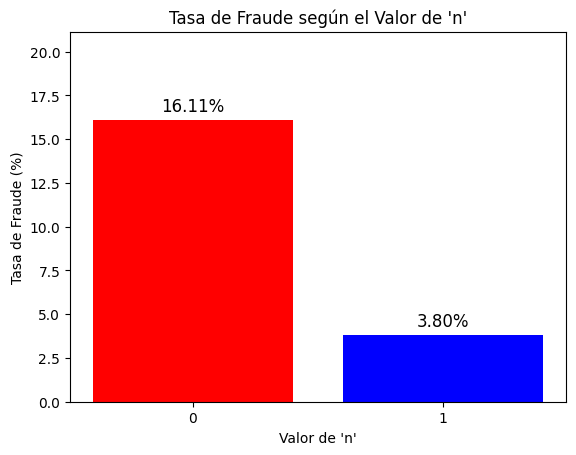

In [58]:
plt.bar(fraude_por_n.index.astype(str), fraude_por_n.values, color=['red', 'blue'])
plt.xlabel("Valor de 'n'")
plt.ylabel("Tasa de Fraude (%)")
plt.title("Tasa de Fraude según el Valor de 'n'")
plt.ylim(0, max(fraude_por_n.values) + 5)

for i, v in enumerate(fraude_por_n.values):
    plt.text(i, v + 0.5, f"{v:.2f}%", ha="center", fontsize=12)

plt.show()

 ### VARIABLES O Y P

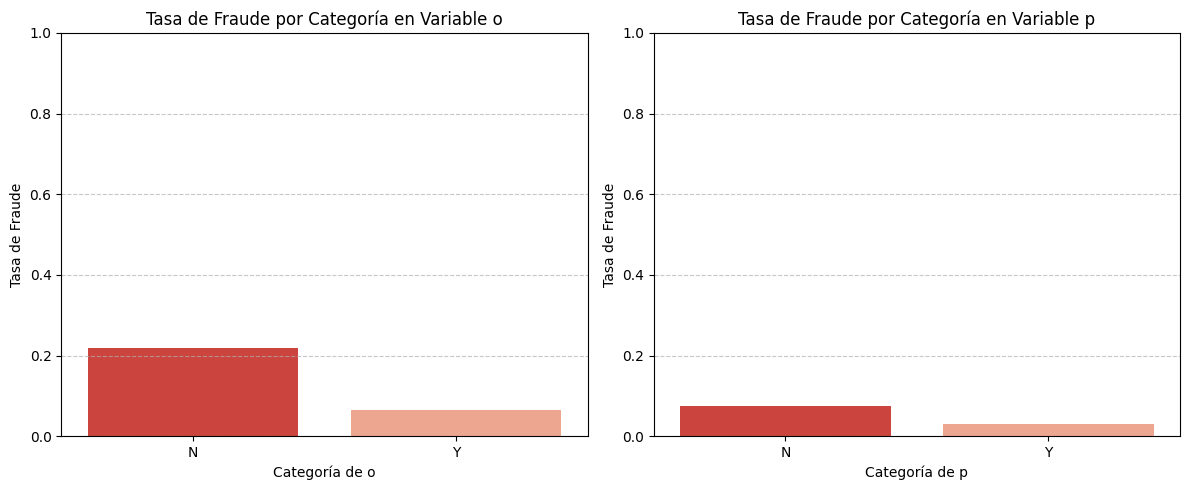

In [59]:
#Tasa de fraude por categoría en `o` y `p`
fraud_rate_o = df_original.groupby('o')['fraude'].mean().reset_index()
fraud_rate_p = df_original.groupby('p')['fraude'].mean().reset_index()

#Total de transacciones por categoría
count_o = df_original['o'].value_counts().reset_index()
count_o.columns = ['o', 'Total Transacciones']
count_p = df_original['p'].value_counts().reset_index()
count_p.columns = ['p', 'Total Transacciones']


fraud_analysis_o = fraud_rate_o.merge(count_o, on='o')
fraud_analysis_p = fraud_rate_p.merge(count_p, on='p')

#Chi cuadrado para `o` y `p`
contingency_o = pd.crosstab(df_original['o'], df_original['fraude'])
chi2_o, p_o, _, _ = stats.chi2_contingency(contingency_o)

contingency_p = pd.crosstab(df_original['p'], df_original['fraude'])
chi2_p, p_p, _, _ = stats.chi2_contingency(contingency_p)

chi2_results_o_p = pd.DataFrame({
    'Variable': ['o', 'p'],
    'Estadístico Chi2': [chi2_o, chi2_p],
    'p-valor': [p_o, p_p]
})

chi2_results_o_p

#Gráfica comparativa de la tasa de fraude por variable y por valor en estas

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

#Gráfico de barras para `o`
sns.barplot(data=fraud_analysis_o, x='o', y='fraude', palette='Reds_r', ax=axes[0])
axes[0].set_xlabel("Categoría de o")
axes[0].set_ylabel("Tasa de Fraude")
axes[0].set_title("Tasa de Fraude por Categoría en Variable o")
axes[0].set_ylim(0, 1)
axes[0].grid(axis='y', linestyle='--', alpha=0.7)

#Gráfico de barras para `p`
sns.barplot(data=fraud_analysis_p, x='p', y='fraude', palette='Reds_r', ax=axes[1])
axes[1].set_xlabel("Categoría de p")
axes[1].set_ylabel("Tasa de Fraude")
axes[1].set_title("Tasa de Fraude por Categoría en Variable p")
axes[1].set_ylim(0, 1)
axes[1].grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

Se puede ver que la tasa de fraude de algunos de los valores de cada una de as variables es más alto indicando que puede haber una relación entre este valor y la tasa de fraude.
Revisando la prueba chi cuadrado de ambas variables de manera individual y su posible relación con la variable fraude, vemos que si existe.

## MÉTRICA DE GANANCIA.

Antes de continuar con el ejercicio de clasificación. Se define la métrica de ganancia de la empresa la cual dicta que de uan transaccion aprobada legitima se obtiene el 25% de ganancia de esta mientras que de una transacción aprobada fraudulenta se obtiene una pérdida del 100% del valor de la transacción.

In [60]:
#100% de pérdida
COSTO_FRAUDE = -1.0  
#25% de ganancia
BENEFICIO_LEGITIMO = 0.25  
#Función para calcular la ganancia financiera de la empresa
def calcular_ganancia(y_true, y_pred, X):
    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = cm.ravel()
    
    monto_fraudulento = X.loc[y_true == 1, 'monto'].sum()
    monto_legitimo = X.loc[y_true == 0, 'monto'].sum()
    
    perdida_por_fraude = FP * COSTO_FRAUDE * (monto_fraudulento / (FP + TP + 1e-6))
    ganancia_por_legitimos = TN * BENEFICIO_LEGITIMO * (monto_legitimo / (TN + FN + 1e-6))
    
    return ganancia_por_legitimos + perdida_por_fraude

## EJERCICIO DE CLASIFICACIÓN

Cómo se ha visto a lo largo de EDA, se han venido creando nuevas variables bien sea para capturar la relación de la variable original con fraude, como lo son las variables creds con la intención de reemplazar las variables categóricas de más alta cardinalidad y en otras ocasiones para tratar de solventar problemas en la calidad de datos como es el caso de o_mising, variable que tiene 72% de missings.
Las variables que se han creado y que se utilizarán en el modelo son entonces:

| VARIABLE ORIGINAL | NUEVA VARIABLE    | TIPO DE VARIABLE | RAZÓN                                      |
|-------------------|------------------|------------------|--------------------------------------------|
| b                | b_missing         | Categórica       | Relación datos faltantes con fraude       |
| c                | c_missing         | Categórica       | Relación datos faltantes con fraude       |
| d                | d_missing         | Categórica       | Relación datos faltantes con fraude       |
| m                | m_missing         | Categórica       | Relación datos faltantes con fraude       |
| o                | o_missing         | Categórica       | Gran proporción de missings               |
| fecha            | dia_semana        | Categórica       | Relación entre los días de la semana y fraude |
| fecha            | high_risk_hour    | Categórica       | Relación entre ciertas horas del día y fraude |
| g                | g_encoded         | Numérica         | Relación entre los países y fraude        |
| j                | high_risk_product | Categórica       | Relación entre ciertos productos y fraude |




Se construye una función que contiene varias de las siguientes fases del modelado:
- Preprocesamiento
- Técnicas de balanceo
- Optimización de Hiperparametros
- Evaluación del modelado
Esta función permitirá evaluar los modelos Logistic Regresion y los modelos XGBoost y LightGBM.
La razón para emplear los dos últimos modelos radican en su conocido rendimiento en clasificación, versatilidad, eficiencia cuando se usa con GPU para acelerar el entrenamiento y buen rendimiento demostrado en ejercicios donde prevalece el desbalance de clases.

Se contempla así para cada modelo una lista de hiperparametros que ayudan en el rendimiento, aprendizaje y que controlan por posible overfitting.
Estas 'grillas' de Hiperparametros será empleada junto con optuna para encontrar los mejores hiperparametros de cada modelo que maximizan la ganancia.
Finalmente se empelarán estos hiperparmetros sobre el modelo y se evaluará contra el set de prueba. Para evaluar los modelos se tendrá en cuenta la ganancia de la empresa, las métricas usuales de clasificación en escenarios desbalanceados (Recall, Precision, f1, matriz de confusión, auc precision recall). Asimismo se podrá ver la importancia de las variables en los modelos así como también los SHAP values en los modelos arbóreos. 


### PREPROCESAMIENTO Y CALIDAD DE DATOS
Para tratar los problemas de calidad de datos y preprocesar las variables se crea un pipeline que de acuerdo al tipo de variable:
- Variables numéricas: imputará valores faltantes con base a la mediana, luego se aplicará un escalador robusto para estandarizar de manera robusta los valores de las variables y tratar con los outliers.
-  Variables categóricas: Se imputarán los valores faltantes creando una categoría adicional 'missing', luego se aplicará OHE para 'numérizar' los valores categóricos (este paso es necesario solo en modelos lineales, no tanto en modelo árboreos, no obstante se realizó para poder aplicar técnicas de sobremuestreo como SMOTE).

### TRATAMIENTO DEL DESBALANCE DE CLASES
Se cuenta además con tres alternativas para tratar el desbalance de clases.
- Por un lado se puede utilizar undersampling (RUS) el cual elimina aleatoriamente observaciones de la clase mayoritaria para nivelar la proporción con la clase minoritaria. Esta alternativa supone una perdida grande de información.
- Por el otro lado se puede utilizar oversampling (SMOTE), el cual generará observaciones adicionales de la clase minoritaria para nivelar la proporción de las clases.
- Finalmente se puede usar Cost Sensitive learning en los modelos Xgboost y LightGBM, indicando que el peso por equivocarse clasificando erróneamente una observación de la clase minoritaria aumentó.

Se utiliza Optuna basado en  para la optimización de hiperparametros de los modelos, adicional a esto se aplica CV para garantizar los resultados obtenidos. La función a maximizar pro el optimizador será la función de ganancia de la empresa.

In [61]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 29 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   a                  150000 non-null  category      
 1   b                  137016 non-null  float64       
 2   c                  137016 non-null  float64       
 3   d                  149635 non-null  float64       
 4   e                  150000 non-null  float64       
 5   f                  149989 non-null  float64       
 6   g                  149806 non-null  category      
 7   h                  150000 non-null  int64         
 8   j                  150000 non-null  category      
 9   k                  150000 non-null  float64       
 10  l                  149989 non-null  float64       
 11  m                  149635 non-null  float64       
 12  n                  150000 non-null  category      
 13  o                  41143 non-null   category

In [62]:
variables_no_modelo = [
    'j', 'g', 'fecha', 'hora', 'o', 'k'
]

In [63]:
#Eliminación de las variables innecesarias del dataset
data_modelo = data.copy()
data_modelo=data_modelo.drop(columns=variables_no_modelo, errors='ignore')

In [64]:
data_modelo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 23 columns):
 #   Column             Non-Null Count   Dtype   
---  ------             --------------   -----   
 0   a                  150000 non-null  category
 1   b                  137016 non-null  float64 
 2   c                  137016 non-null  float64 
 3   d                  149635 non-null  float64 
 4   e                  150000 non-null  float64 
 5   f                  149989 non-null  float64 
 6   h                  150000 non-null  int64   
 7   l                  149989 non-null  float64 
 8   m                  149635 non-null  float64 
 9   n                  150000 non-null  category
 10  p                  150000 non-null  category
 11  monto              150000 non-null  float64 
 12  score              150000 non-null  int64   
 13  fraude             150000 non-null  int64   
 14  b_missing          150000 non-null  category
 15  c_missing          150000 non-null

In [65]:
#Separación de la variable objetivo
y = data_modelo['fraude']
X = data_modelo.drop(columns=['fraude'])

In [92]:
#Función para optimizar, entrenar y evaluar
def optimize_train_evaluate(X, y, model_name, balance_name, device="cpu", n_trials=50):
    #Parámetro de CPU por defecto, pero se puede usar GPU
    #División de datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    #tipos de variables
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    #Preprocesamiento
    #Variables numéricas
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  #Imputación missings con la mediana
        ('scaler', RobustScaler())  #Escalado robusto para outliers
    ])
    #Variables categóricas
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),  #Imputación con nueva categoría missing
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])  #Numerización de variables categóricas usando OHE

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], verbose_feature_names_out=False)
    
    #Estrategias de balanceo
    balancing_strategies = {
        "SMOTE": SMOTE(random_state=42),  #Oversampling
        "RUS": RandomUnderSampler(random_state=42),  #Undersampling
        "CostSensitive": None,  #Cost sensitive learning
        "None": None
    }
    
    balance_strategy = balancing_strategies.get(balance_name, None)

    #Cost sensitive learning cálculo de scale_pos_weight
    scale_pos_weight = None
    if balance_name == "CostSensitive" and model_name in ["XGBoost", "LightGBM"]:
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    #Función Objetivo de Optuna
    def objective(trial):
        hyperparams = {}
        
        #Regresión logística e hiperparámetros
        if model_name == "LogisticRegression":
            use_class_weight = balance_name == "CostSensitive"
        
            penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
            solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs", "newton-cg"])
            
            # Verificar si la combinación de solver y penalty es válida
            if penalty == "l1" and solver not in ["liblinear", "saga"]:
                raise optuna.exceptions.TrialPruned()
        
            hyperparams = {
                "C": trial.suggest_float("C", 0.01, 10, log=True),
                "max_iter": trial.suggest_int("max_iter", 100, 500),
                "penalty": penalty,
                "solver": solver
            }
            
            if use_class_weight:
                hyperparams["class_weight"] = "balanced"
            if solver in ["liblinear", "saga"]:
                hyperparams["random_state"] = 42
            model = LogisticRegression(**hyperparams)

        #XGBoost e hiperparámetros
        elif model_name == "XGBoost":
            hyperparams = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "gamma": trial.suggest_float("gamma", 0.01, 1.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "tree_method": "gpu_hist" if device == "gpu" else "hist",
                "random_state": 42,
                "scale_pos_weight": scale_pos_weight if scale_pos_weight else 1.0,
                
            }
            model = XGBClassifier(**hyperparams)

        #LightGBM e hiperparámetros
        elif model_name == "LightGBM":
            hyperparams = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "num_leaves": trial.suggest_int("num_leaves", 20, 120),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "device": device,
                "verbose" : -1,
                "random_state": 42,
                "bagging_seed": 42,
                "scale_pos_weight": scale_pos_weight if scale_pos_weight else 1.0
            }
            model = LGBMClassifier(**hyperparams)

        else:
            raise ValueError(f"Modelo {model_name} no reconocido")

        #Pipeline para aplicar preprocesamiento -> balanceo -> clasificación
        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('balancer', balance_strategy),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        return calcular_ganancia(y_test, y_pred, X_test)  #Se calcula la ganancia de la empresa

    #Optimización con Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    #Obtención de los mejores hiperparámetros
    best_params = study.best_params

    print("\n Hiperparámetros Óptimos:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    #Entrenamiento del modelo final con los mejores hiperparámetros
    if model_name == "XGBoost":
        best_model = XGBClassifier(**best_params)
    elif model_name == "LightGBM":
        best_model = LGBMClassifier(**best_params)
    elif model_name == "LogisticRegression":
        best_model = LogisticRegression(**best_params)
    else:
        raise ValueError(f"Modelo {model_name} no reconocido")

    #Pipeline con mejores hiperparámetros preprocesamiento -> balanceo -> clasificación
    best_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('balancer', balance_strategy),
        ('classifier', best_model)
    ])
    
    best_pipeline.fit(X_train, y_train)
    y_pred = best_pipeline.predict(X_test)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    #Evaluación final
    print("\n Métricas del Mejor Modelo:")
    ganancia = calcular_ganancia(y_test, y_pred, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_values, precision_values)
    
    #Imprimir métricas
    print(f"Ganancia: {ganancia:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-RC-AUC: {pr_auc:.4f}")
    
    #Gráficos
    
    #Matriz de Confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()
    
    #Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.title("Curva ROC")
    plt.legend()
    plt.show()
    
    #Curva de Precisión-Recall
    plt.figure(figsize=(6, 5))
    plt.plot(recall_values, precision_values, label=f"PR AUC = {pr_auc:.4f}", color="green")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precisión-Recall")
    plt.legend()
    plt.show()


    
    #Convertir Data frame de X_test
    X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=best_pipeline.named_steps['preprocessor'].get_feature_names_out())

    #Importancia de características
    if hasattr(best_model, "feature_importances_"):
        feature_importances = best_model.feature_importances_
        importance_data = pd.DataFrame({
            "Feature": X_test_transformed.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)
    
        print("\nImportancia de Características:")
        print(importance_data.head(20))
    
        #Gráfica de la importancia de las características
        plt.figure(figsize=(10, 6))
        plt.barh(importance_data['Feature'][:10], importance_data['Importance'][:10])
        plt.gca().invert_yaxis()
        plt.xlabel("Importance")
        plt.title("Feature Importances")
        plt.show()
    else:
        print("\nEste modelo no tiene feature_importances_ (solo disponible en modelos de árboles).")

    #SHAP values
    #Solo aplica a modelos basados en árboles
    if model_name in ["XGBoost", "LightGBM"]:  
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_transformed)
        shap.summary_plot(shap_values, X_test_transformed)
    elif model_name == "LogisticRegression":
        print("\nSHAP no es compatible directamente con LogisticRegression.")
    else:
        print("\nSHAP no está implementado para este modelo.")

    return best_pipeline

## EJERCICIO DE CLASIFICACIÓN

Se ejecutó la función anterior para evaluar los siguientes modelos:
- Regresión Logistica ("LogisticRegression" se introduce de esta manera en la función como parámetro)
- XGBoost ("XGBoost" se introduce de esta manera en la función como parámetro)
- LightGBM ("LightGBM" se introduce de esta manera en la función como parámetro)

En combinacion con las técnicas de balanceo de clases:
- Undersampling ("RUS" se introduce de esta manera en la función como parámetro)
- Oversampling ("SMOTE"  se introduce de esta manera en la función como parámetro)
- Cost Sensitive Learning ("CostSensitive" para el caso de la regresión logística para que use class_weitgh='balanced', y "CostSensitive" para el caso de Xgboost y LightGBM para que se use scale_pos_weight.)

**RECORDAR**: Que se puede cambiar el device a 'cpu' por si no est aconfigurada la gpu.

### REGRESIÓN LOGÍSTICA COST SENSITIVE

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
penalty: l2
solver: saga
C: 1.1119433121987448
max_iter: 283

 Métricas del Mejor Modelo:
Ganancia: 238111.41
Accuracy: 0.9500
Precision: 0.5714
Recall: 0.0027
F1-Score: 0.0053
ROC-AUC: 0.7626
PR-RC-AUC: 0.2080


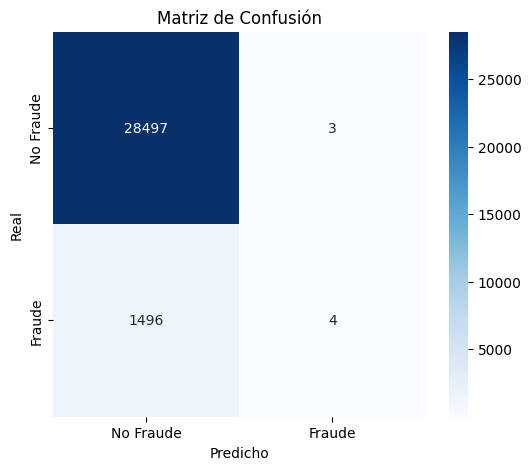

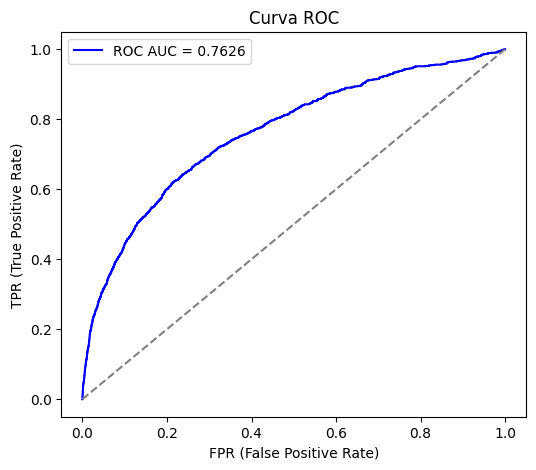

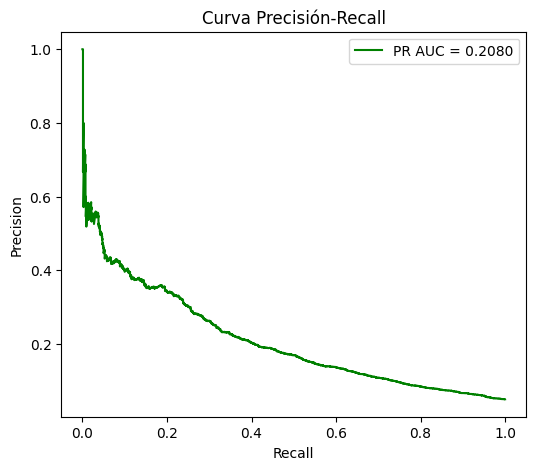


Este modelo no tiene feature_importances_ (solo disponible en modelos de árboles).

SHAP no es compatible directamente con LogisticRegression.


In [74]:
lr_cs = optimize_train_evaluate(X, y, "LogisticRegression", "CostSensitive", device="cpu", n_trials=50)

### REGRESIÓN LOGÍSTICA SMOTE

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
penalty: l1
solver: saga
C: 0.32988127390775746
max_iter: 470

 Métricas del Mejor Modelo:
Ganancia: 201040.40
Accuracy: 0.7982
Precision: 0.1608
Recall: 0.7193
F1-Score: 0.2628
ROC-AUC: 0.8346
PR-RC-AUC: 0.3083


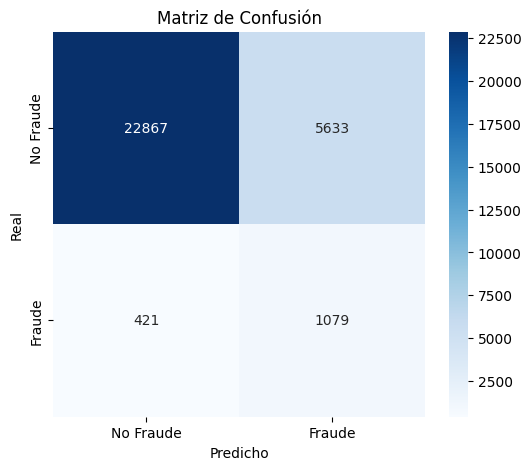

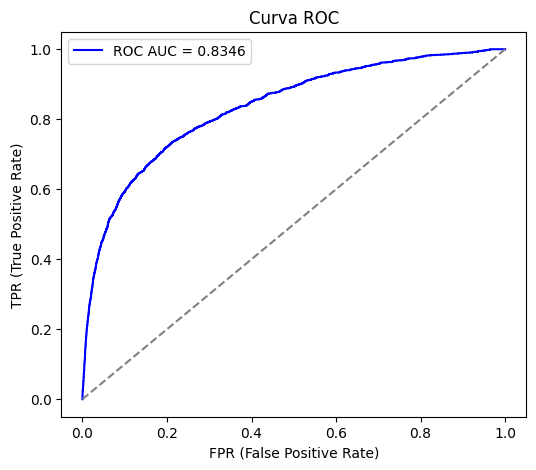

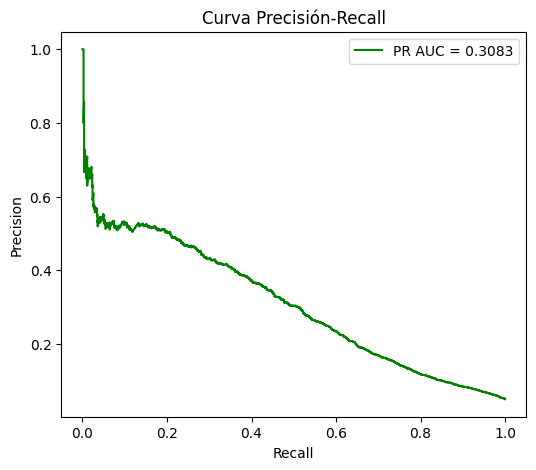


Este modelo no tiene feature_importances_ (solo disponible en modelos de árboles).

SHAP no es compatible directamente con LogisticRegression.


In [73]:
lr_sm = optimize_train_evaluate(X, y, "LogisticRegression", "SMOTE", device="cpu", n_trials=50)

### REGRESIÓN LOGÍSTICA RUS

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
penalty: l1
solver: saga
C: 0.026929519988996224
max_iter: 215

 Métricas del Mejor Modelo:
Ganancia: 201113.08
Accuracy: 0.7890
Precision: 0.1580
Recall: 0.7433
F1-Score: 0.2605
ROC-AUC: 0.8514
PR-RC-AUC: 0.3438


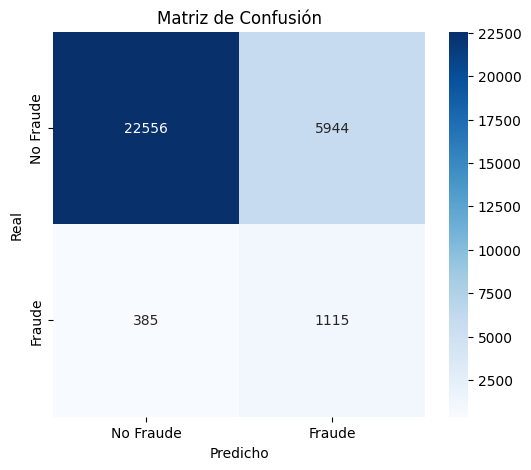

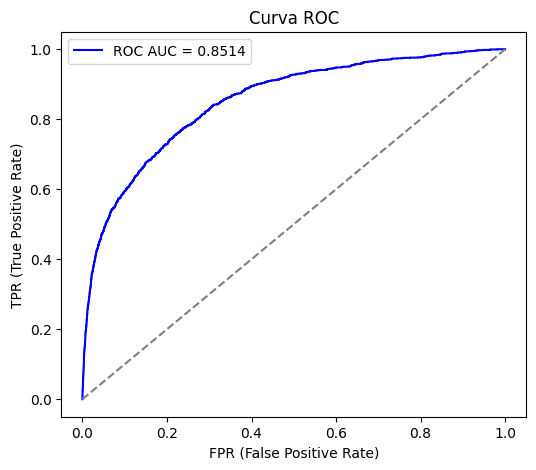

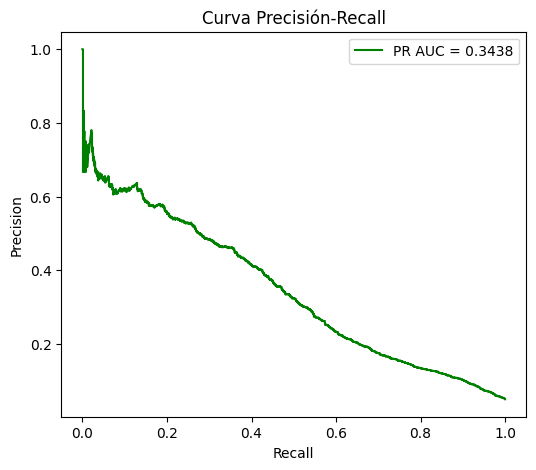


Este modelo no tiene feature_importances_ (solo disponible en modelos de árboles).

SHAP no es compatible directamente con LogisticRegression.


In [75]:
lr_rs = optimize_train_evaluate(X, y, "LogisticRegression", "RUS", device="cpu", n_trials=50)

### XGBOOST COST SENSITIVE LEARNING

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 273
max_depth: 10
learning_rate: 0.19739718803757345
gamma: 0.29141876329782906
subsample: 0.637578341632305
colsample_bytree: 0.688760358214465

 Métricas del Mejor Modelo:
Ganancia: 247791.67
Accuracy: 0.9555
Precision: 0.6219
Recall: 0.2807
F1-Score: 0.3868
ROC-AUC: 0.8718
PR-RC-AUC: 0.4368


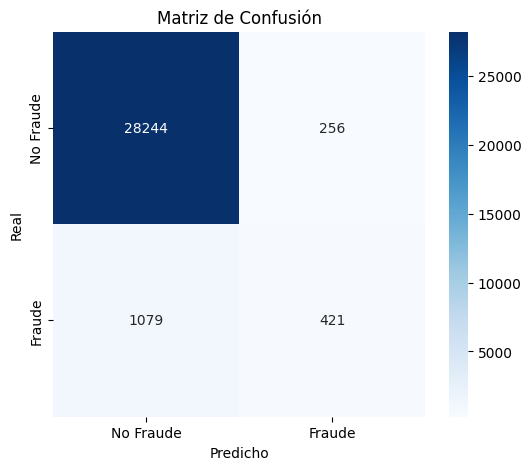

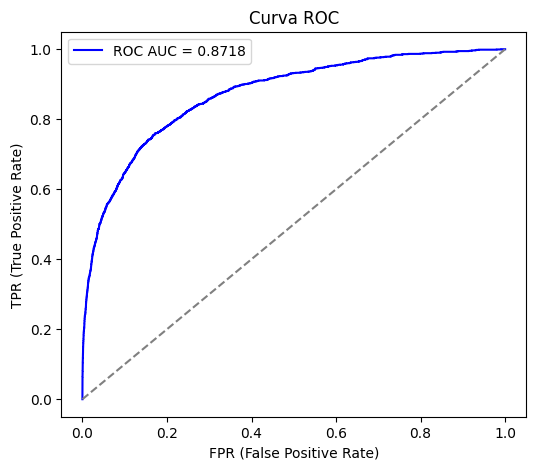

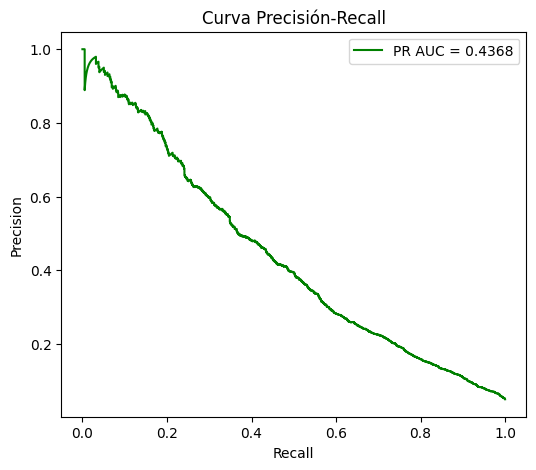


Importancia de Características:
                Feature  Importance
21       o_missing_True    0.180082
15                  n_1    0.103095
11    high_risk_product    0.070545
10            g_encoded    0.056749
9                 score    0.044088
28  high_risk_hour_True    0.030173
16                  p_Y    0.029555
12                  a_2    0.028687
17       b_missing_True    0.027359
20       m_missing_True    0.026592
14                  a_4    0.024917
19       d_missing_True    0.024044
4                     f    0.024036
6                     l    0.022611
7                     m    0.022446
18       c_missing_True    0.022037
3                     e    0.021662
1                     c    0.021541
8                 monto    0.021220
13                  a_3    0.021150


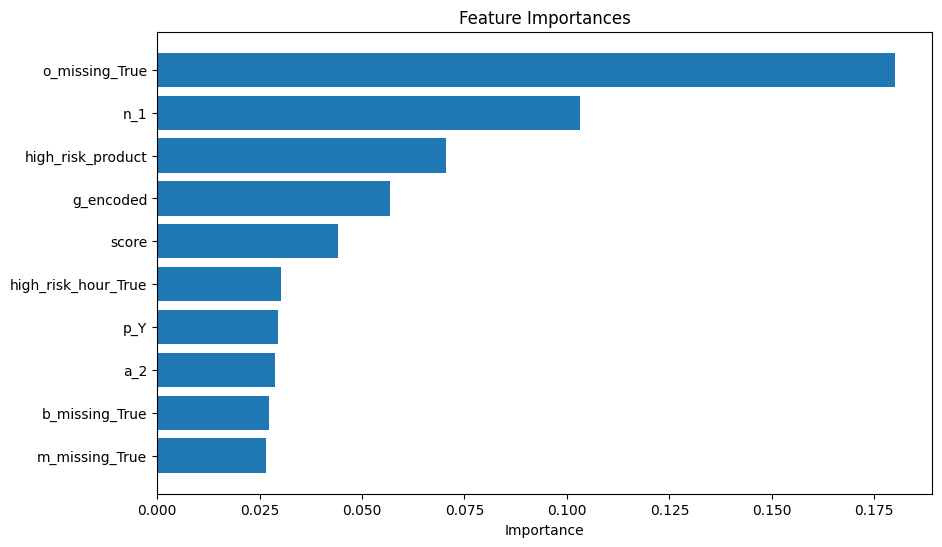

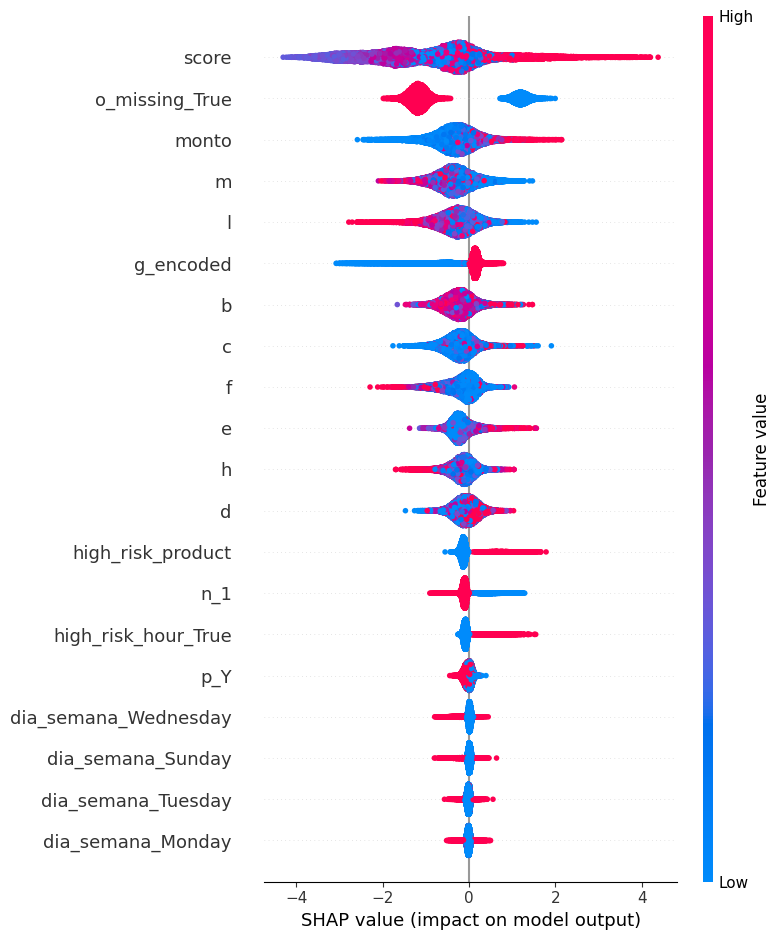

In [76]:
xgb_cs = optimize_train_evaluate(X, y, "XGBoost", "CostSensitive", device="gpu", n_trials=50)

### XGBOOST SMOTE

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 297
max_depth: 10
learning_rate: 0.13288668435521295
gamma: 0.01259261584911834
subsample: 0.9702674732225478
colsample_bytree: 0.6242834202553679

 Métricas del Mejor Modelo:
Ganancia: 251570.18
Accuracy: 0.9571
Precision: 0.6519
Recall: 0.3047
F1-Score: 0.4153
ROC-AUC: 0.8736
PR-RC-AUC: 0.4518


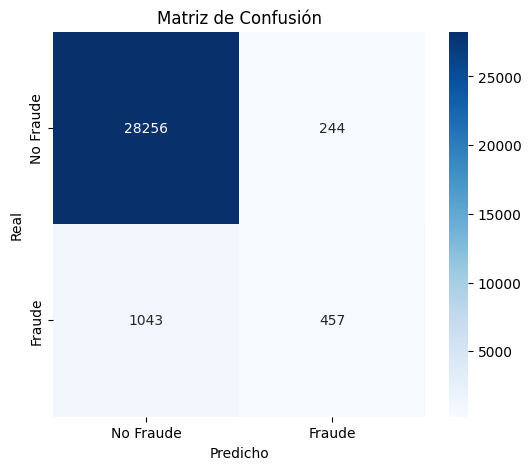

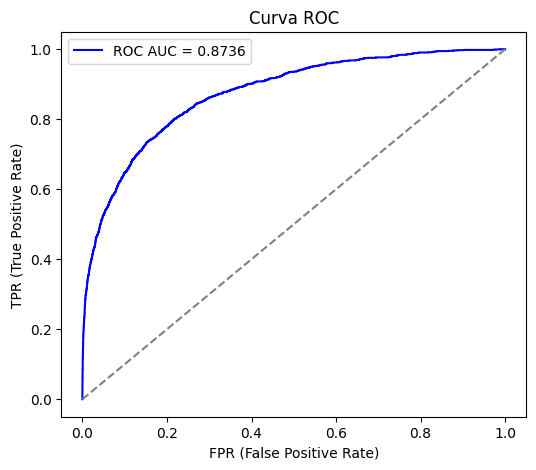

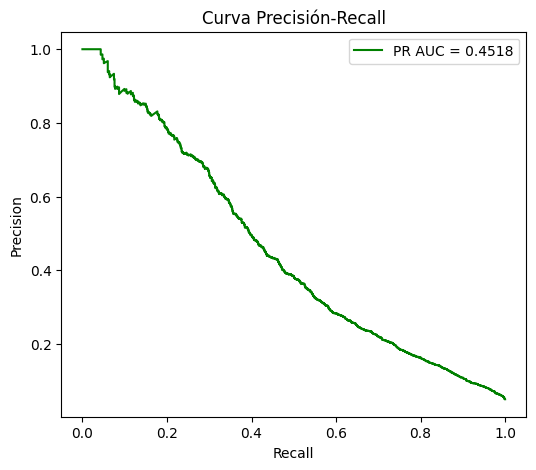


Importancia de Características:
                 Feature  Importance
21        o_missing_True    0.334533
15                   n_1    0.118618
11     high_risk_product    0.083249
28   high_risk_hour_True    0.050065
10             g_encoded    0.046547
16                   p_Y    0.042339
9                  score    0.032835
4                      f    0.025939
24     dia_semana_Sunday    0.025058
14                   a_4    0.022277
22     dia_semana_Monday    0.020431
2                      d    0.020345
25   dia_semana_Thursday    0.020054
26    dia_semana_Tuesday    0.019727
23   dia_semana_Saturday    0.019316
27  dia_semana_Wednesday    0.019107
5                      h    0.017175
12                   a_2    0.015664
13                   a_3    0.010049
18        c_missing_True    0.010021


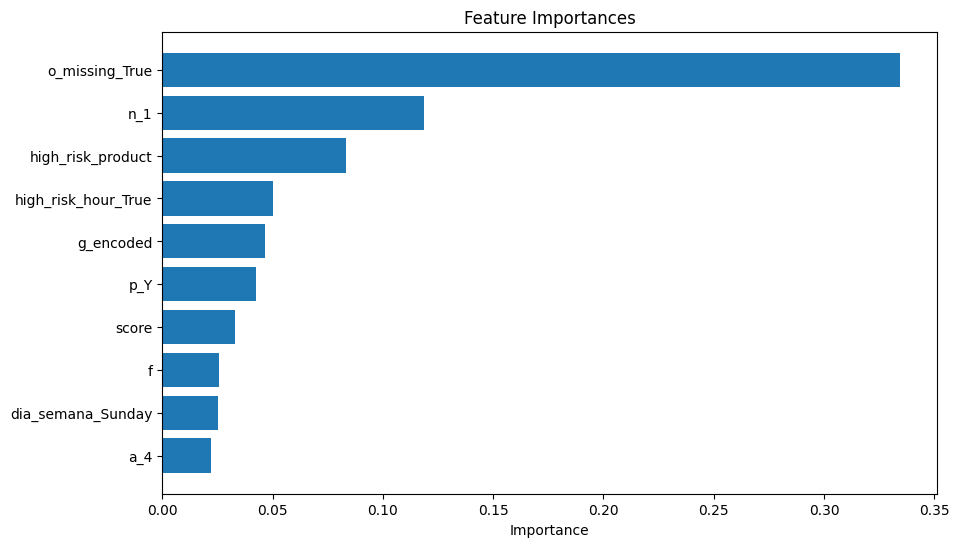

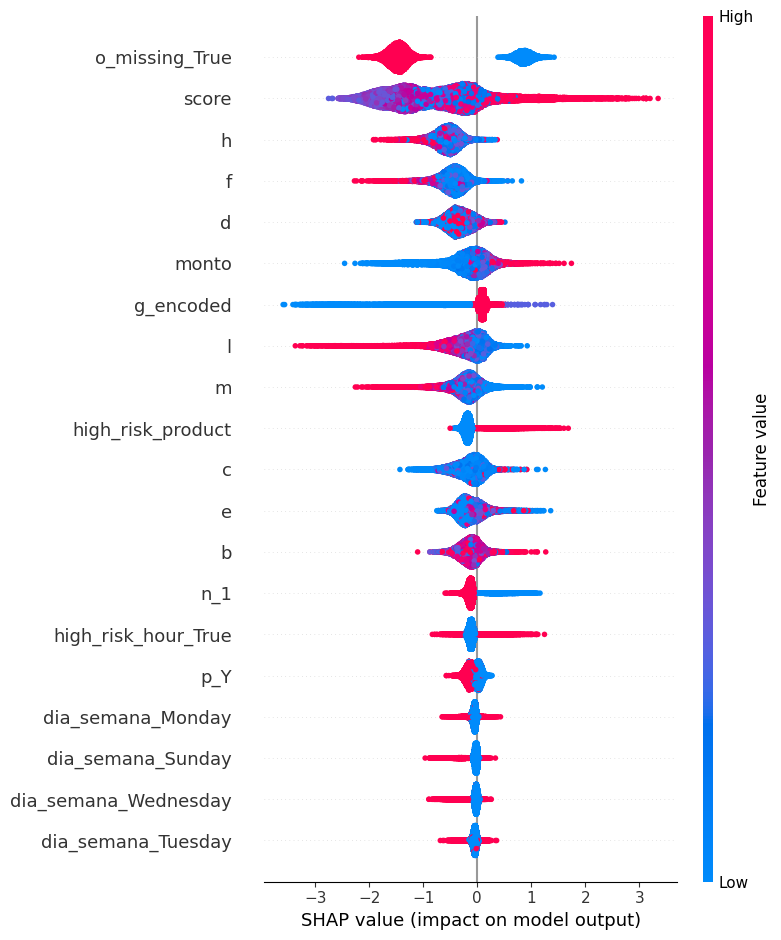

In [77]:
xgb_sm = optimize_train_evaluate(X, y, "XGBoost", "SMOTE", device="gpu", n_trials=50)

### XGBOOST RUS

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 280
max_depth: 3
learning_rate: 0.0716177648543489
gamma: 0.04993999254975916
subsample: 0.9240555935155416
colsample_bytree: 0.8413795949525977

 Métricas del Mejor Modelo:
Ganancia: 206257.53
Accuracy: 0.8175
Precision: 0.1902
Recall: 0.8133
F1-Score: 0.3083
ROC-AUC: 0.8953
PR-RC-AUC: 0.4522


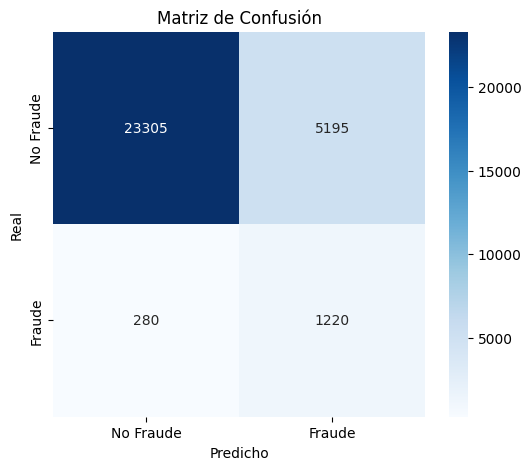

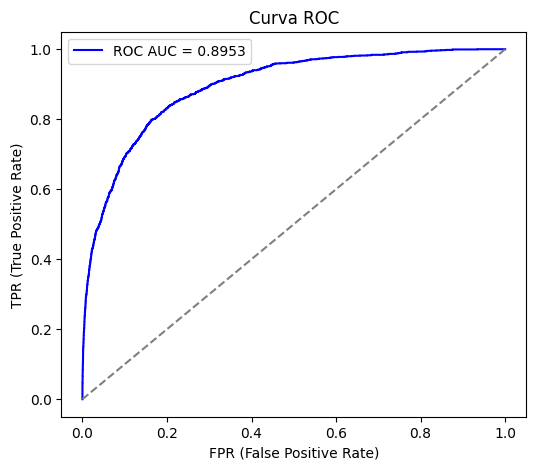

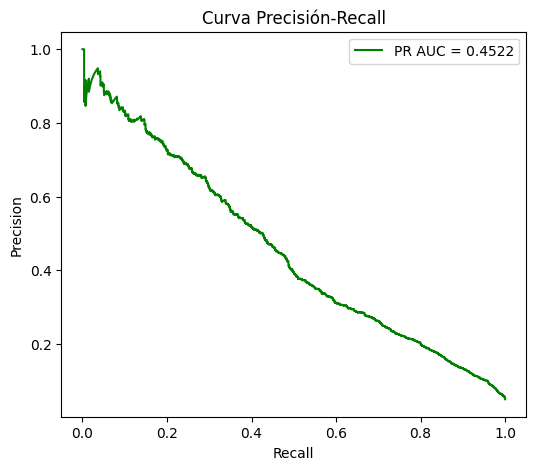


Importancia de Características:
                Feature  Importance
21       o_missing_True    0.433287
15                  n_1    0.109729
9                 score    0.107688
11    high_risk_product    0.065001
10            g_encoded    0.036004
4                     f    0.034712
28  high_risk_hour_True    0.024527
7                     m    0.017952
6                     l    0.017684
8                 monto    0.013111
12                  a_2    0.010468
16                  p_Y    0.009924
25  dia_semana_Thursday    0.009628
0                     b    0.009524
1                     c    0.008834
17       b_missing_True    0.008633
3                     e    0.008300
2                     d    0.008209
14                  a_4    0.008160
23  dia_semana_Saturday    0.007827


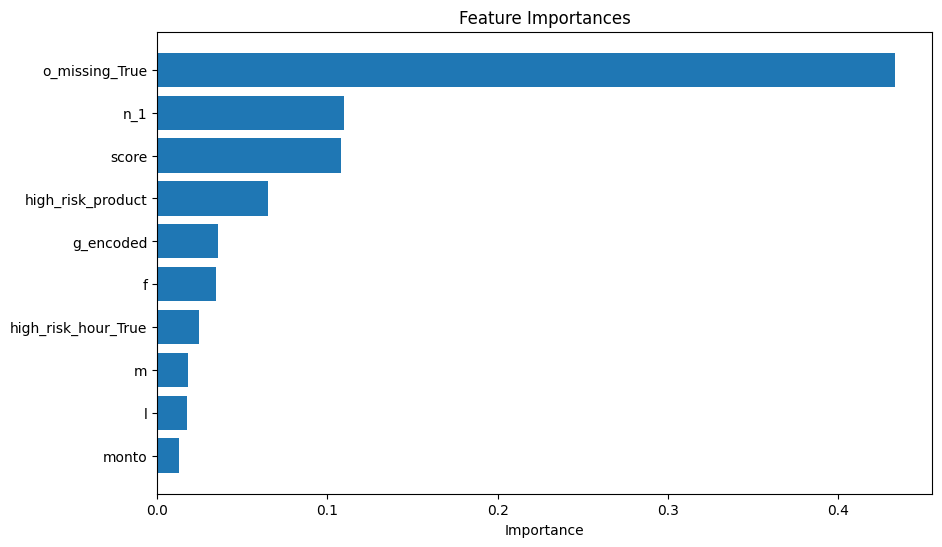

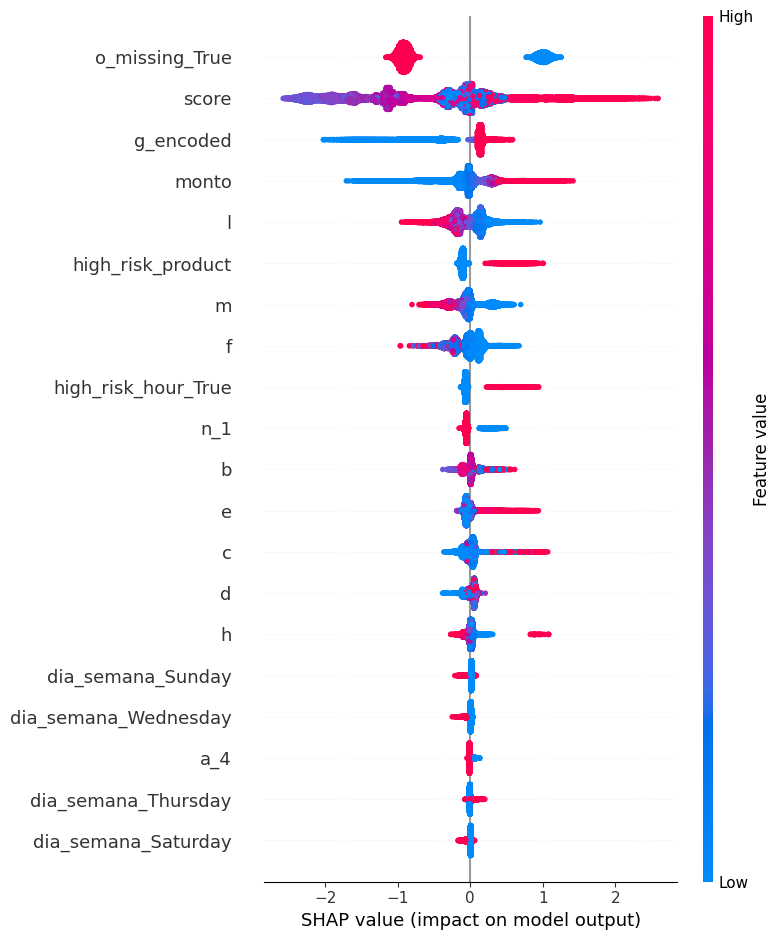

In [78]:
xgb_rs = optimize_train_evaluate(X, y, "XGBoost", "RUS", device="gpu", n_trials=50)

### LIGHTGBM COST SENSITIVE LEARNING

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 261
max_depth: 14
num_leaves: 118
subsample: 0.5000169330513898

 Métricas del Mejor Modelo:
Ganancia: 250305.01
Accuracy: 0.9562
Precision: 0.6444
Recall: 0.2767
F1-Score: 0.3871
ROC-AUC: 0.8873
PR-RC-AUC: 0.4663


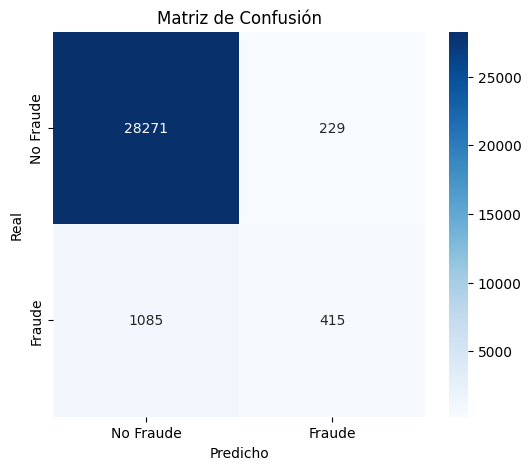

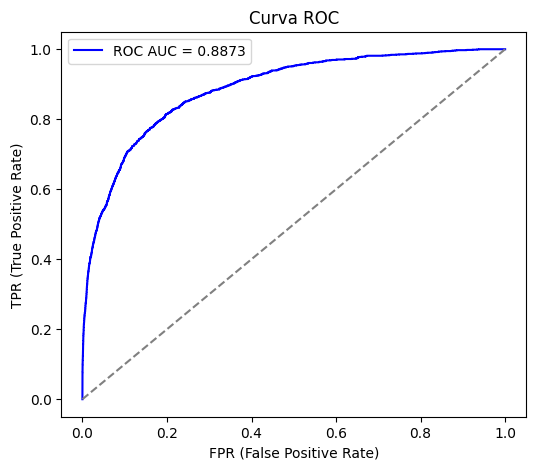

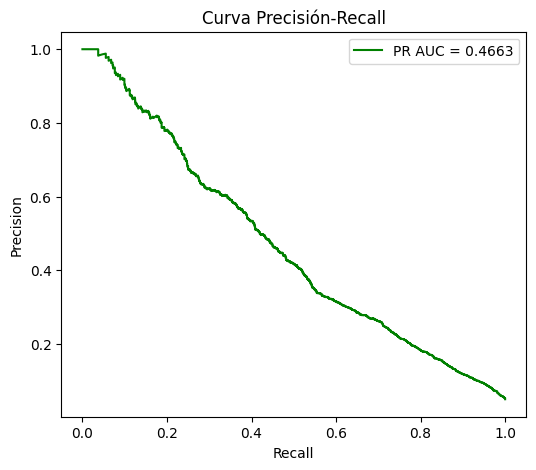


Importancia de Características:
                 Feature  Importance
6                      l        3549
8                  monto        3431
0                      b        3262
1                      c        3246
7                      m        3051
9                  score        2981
5                      h        2287
4                      f        2046
3                      e        1952
2                      d        1626
10             g_encoded         365
21        o_missing_True         308
11     high_risk_product         289
28   high_risk_hour_True         254
22     dia_semana_Monday         215
26    dia_semana_Tuesday         214
15                   n_1         196
25   dia_semana_Thursday         186
23   dia_semana_Saturday         185
27  dia_semana_Wednesday         171


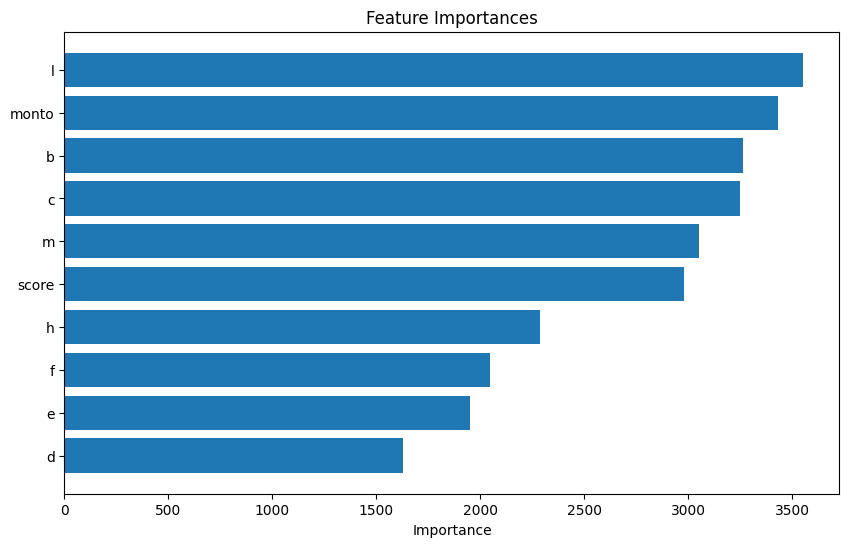

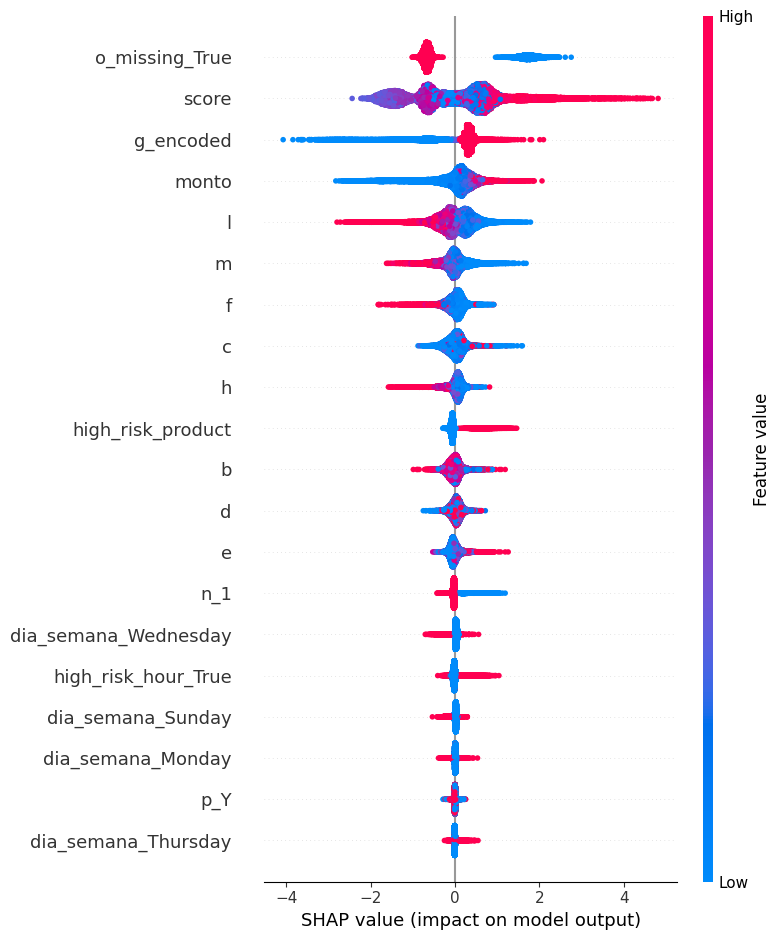

In [79]:
lgbm_cs = optimize_train_evaluate(X, y, "LightGBM", "CostSensitive", device="gpu", n_trials=50)

### LIGHTGBM SMOTE

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 299
max_depth: 11
num_leaves: 85
subsample: 0.7856515550604247

 Métricas del Mejor Modelo:
Ganancia: 251464.27
Accuracy: 0.9571
Precision: 0.6510
Recall: 0.3047
F1-Score: 0.4151
ROC-AUC: 0.8815
PR-RC-AUC: 0.4625


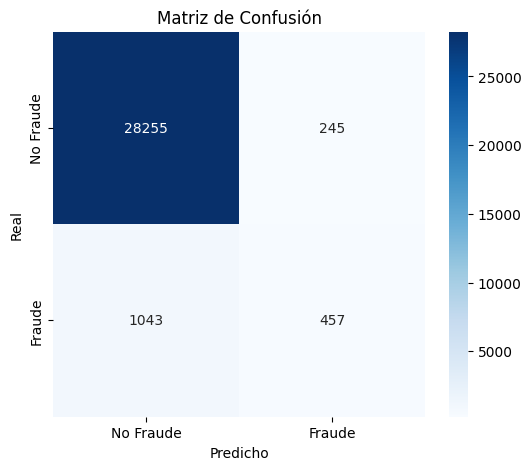

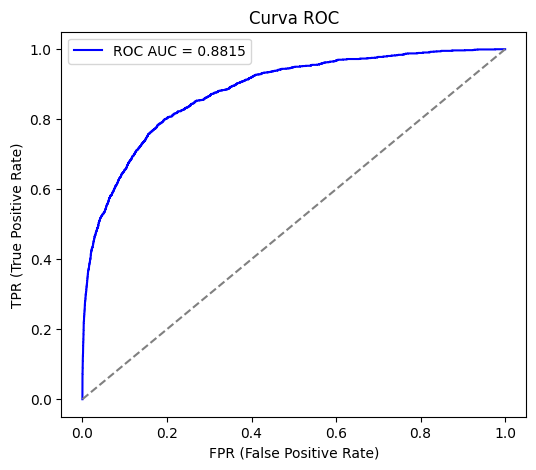

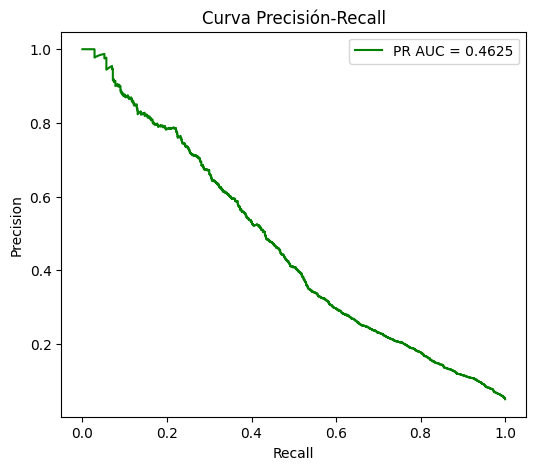


Importancia de Características:
                 Feature  Importance
9                  score        3012
5                      h        2577
4                      f        2233
8                  monto        2160
6                      l        2069
1                      c        2043
0                      b        1920
7                      m        1863
2                      d        1784
3                      e        1243
21        o_missing_True         503
10             g_encoded         473
11     high_risk_product         344
28   high_risk_hour_True         338
15                   n_1         301
22     dia_semana_Monday         270
27  dia_semana_Wednesday         264
26    dia_semana_Tuesday         258
16                   p_Y         249
25   dia_semana_Thursday         235


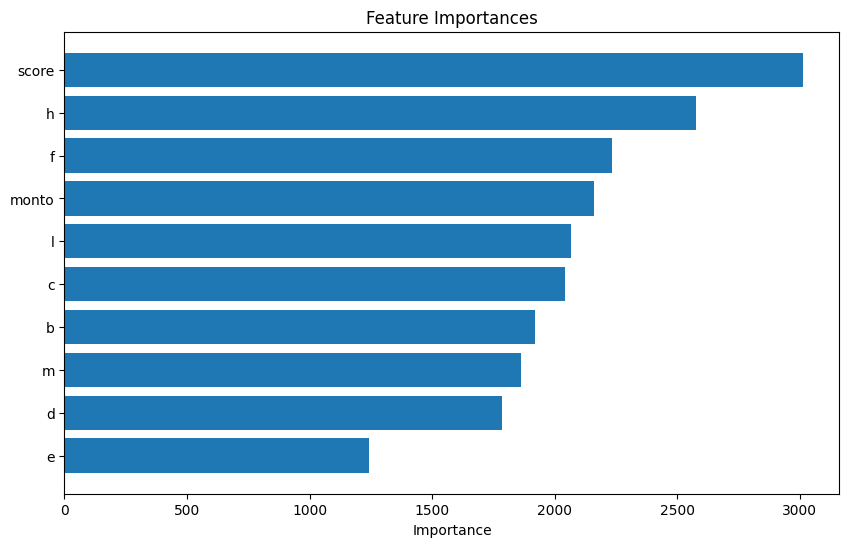

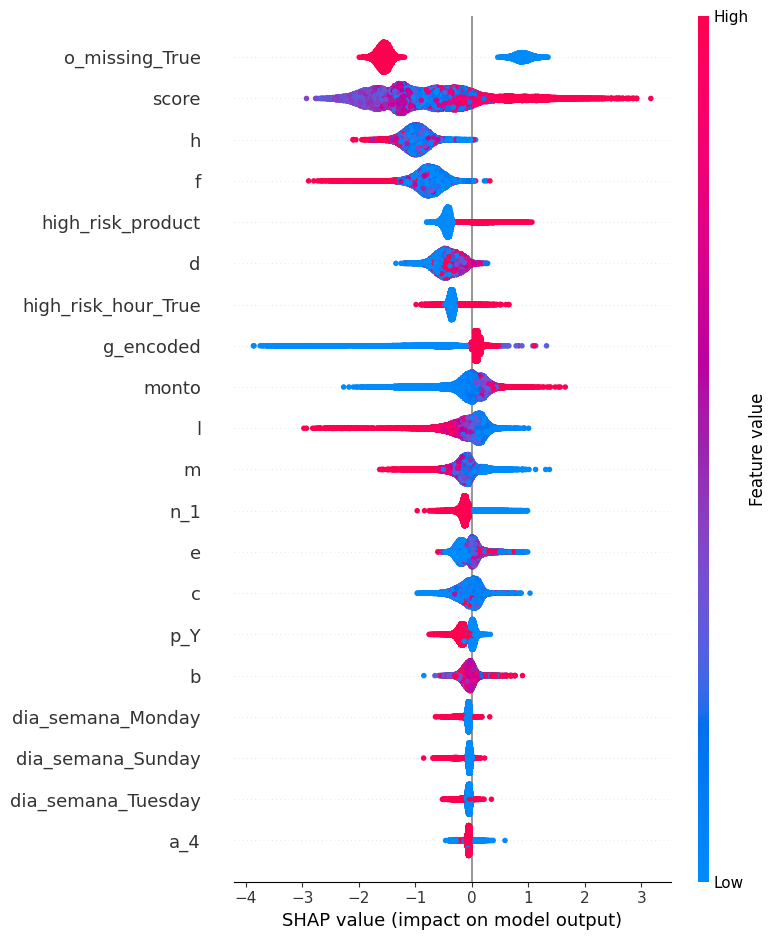

In [93]:
lgbm_sm = optimize_train_evaluate(X, y, "LightGBM", "SMOTE", device="gpu", n_trials=50)

### LIGHTGBM RUS

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 224
max_depth: 3
num_leaves: 60
subsample: 0.8477600070046407

 Métricas del Mejor Modelo:
Ganancia: 206435.82
Accuracy: 0.8176
Precision: 0.1910
Recall: 0.8180
F1-Score: 0.3097
ROC-AUC: 0.8949
PR-RC-AUC: 0.4494


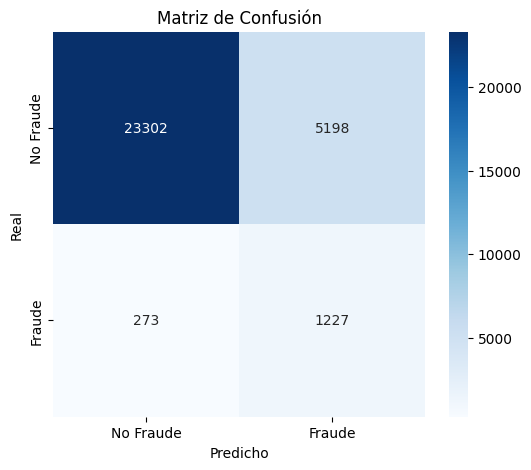

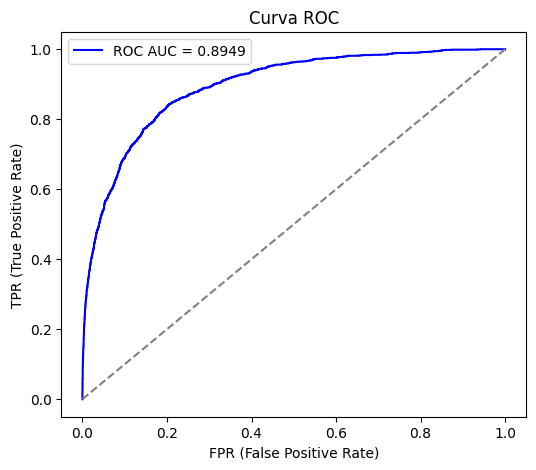

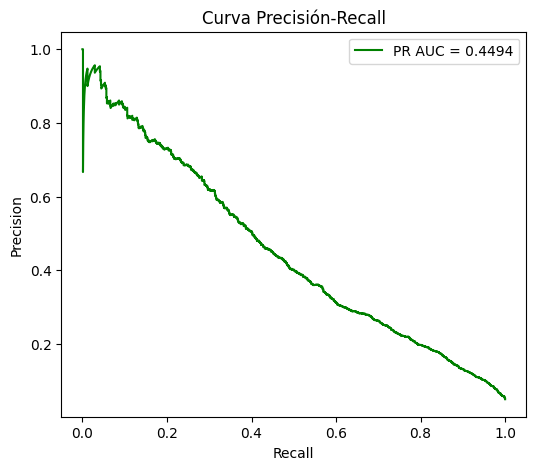


Importancia de Características:
                 Feature  Importance
9                  score         235
8                  monto         150
6                      l         139
1                      c         127
0                      b         126
4                      f         106
7                      m         106
10             g_encoded          74
3                      e          72
2                      d          69
21        o_missing_True          63
5                      h          61
11     high_risk_product          30
28   high_risk_hour_True          29
15                   n_1          16
24     dia_semana_Sunday          16
25   dia_semana_Thursday          15
27  dia_semana_Wednesday          10
23   dia_semana_Saturday           9
13                   a_3           8


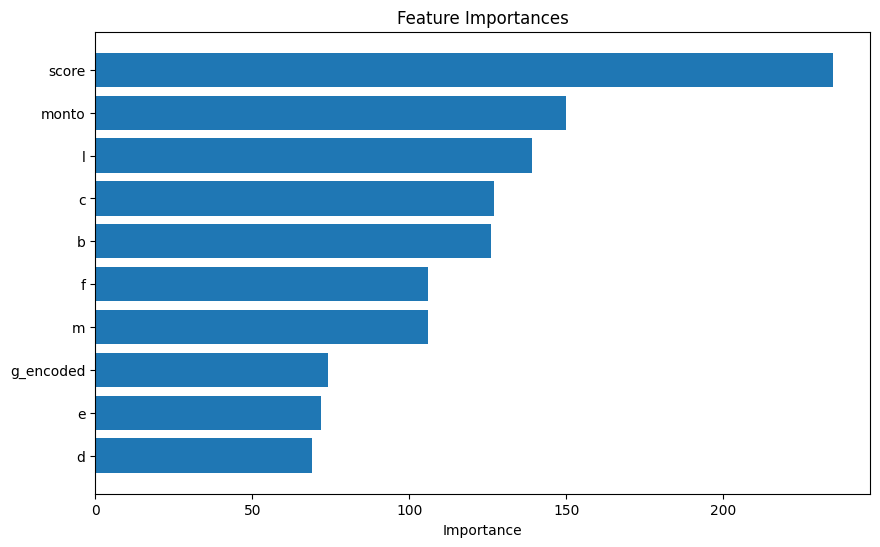

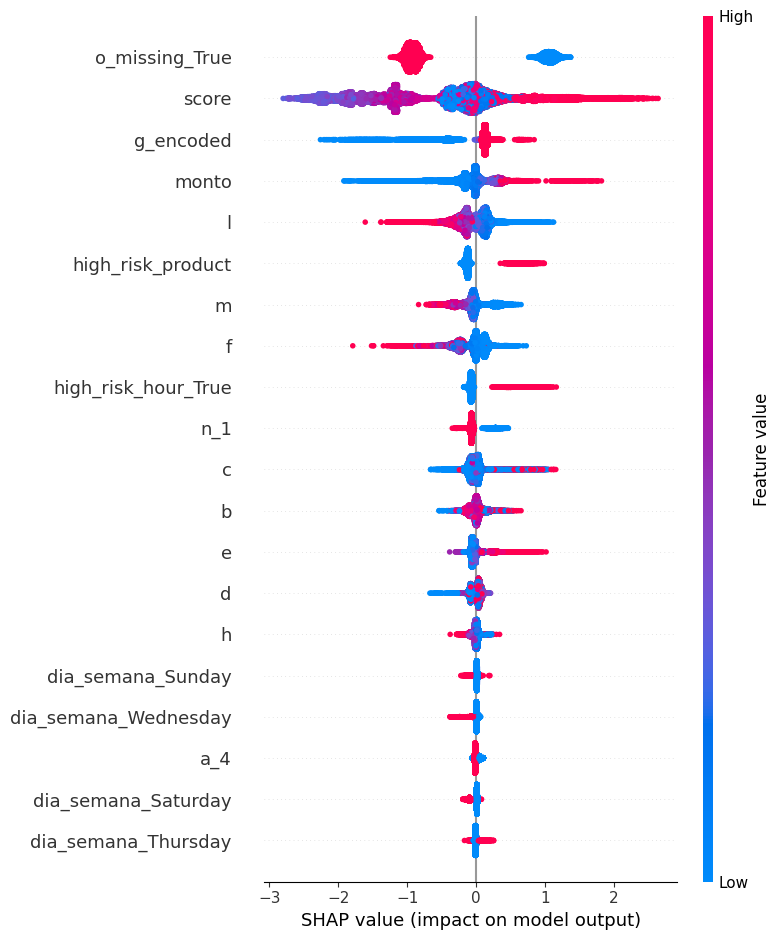

In [81]:
lgbm_rs = optimize_train_evaluate(X, y, "LightGBM", "RUS", device="gpu", n_trials=50)

## EVALUACIÓN DE RESULTADOS

Hallazgos:
- Es intersante ver como todos los modelos obtienen el menor rendimiento cuando usan latécnica de balanceo RUS. Quiz la pérdida d einformación producto de la reducción de observaciones hace qu eel modelo no aprenda relaciones inherentes entre las variables independientes y la objetivo. No obstante, es muy intersante ver que cuando se usa este método de balanceo, todos los modelos obtienen un recall muy alto, esto se corrobora con las matrices de confusión. Esto nos indicaría que cuando se usa RUS, el modelo logr aatrapar una gran cantidad de las transacciones fraudulentas, pero cree que muchas más lo son cuando no lo son y son legitimas, es decir, que aumenta la cantidad de Falsos positivos y se obtiene una precision muy baja.
- Cuando se emplean métodos de balanceo como el SMOTE o Cost Sensitive Learning, se obtienen los mejores resultados en términos de ganancia. No obstante el recall no es muy alto, porqu eno logra capturar los fraudes reales, dejando pasar fraudes al haberlso predicho como legitimos (Falsos negativos).
- El modelo con mejor rendimiento en base a la métrica de ganancia es la regresión logística usando Cost Sensitive Leraning. Este modelo redujo mucho los Falsos Positivos a expensas de los Falsos Negativos. El problema de este modelo es que prácticamente esta dejando pasar todo el fraude, y las ganancias que obtiene son de las transacciones legitimas.
Otros modelos también obtuvieron valores de ganancia altos y tienen un mejor balance entre recall y precisión como el LightGBM que usa SMOTE o cost Sensitive Learning, estos logran capturar más fraudes, aunque bloquean transacciones legitimas.


## BONUS FUNCIÓN QUE OPTIMIZA EL UMBRAL DE DECISIÓN PARA MAXIMIZAR LA GANANCIA.

Se añade la optimización de los umbrales de decisión.
Por defecto los modelos tienen el umbral de 0.5 para determinar cuando se clasifica una observación como clase 1 o 0.
Se puede entonces manipular el umbral de decisión en función de maximizar la ganancia.
Esta implementación es la aquí presentada.
Dejo esto como adicional, porque si bien se maximiza la ganancia maquiavélicamente a costa de disminuir los falsos positivos. Lo cual desde el punto de vista teórico cumple el cometido del ejercicio de maximización, pero es muy extremo.

In [85]:
#Función para optimizar, entrenar, evaluar y ajustar umbral
def optimize_train_evaluate_op_th(X, y, model_name, balance_name, device="cpu", n_trials=50):
    #Parámetro de CPU por defecto, pero se puede usar GPU
    #División de datos en train y test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    
    #Tipos de variables
    categorical_features = X.select_dtypes(include=['category', 'object']).columns.tolist()
    numerical_features = X.select_dtypes(include=['float64', 'int64']).columns.tolist()
    
    #Preprocesamiento
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', RobustScaler())
    ])
    
    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ])

    preprocessor = ColumnTransformer([
        ('num', numeric_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ], verbose_feature_names_out=False)
    
    # Estrategias de balanceo
    balancing_strategies = {
        "SMOTE": SMOTE(random_state=42),
        "RUS": RandomUnderSampler(random_state=42),
        "CostSensitive": None,
        "None": None
    }
    
    balance_strategy = balancing_strategies.get(balance_name, None)

    #Cost sensitive learning cálculo de scale_pos_weight
    scale_pos_weight = None
    if balance_name == "CostSensitive" and model_name in ["XGBoost", "LightGBM"]:
        scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()
    
    #Función Objetivo de Optuna
    def objective(trial):
        hyperparams = {}
        
        if model_name == "LogisticRegression":
            use_class_weight = balance_name == "CostSensitive"
            penalty = trial.suggest_categorical("penalty", ["l1", "l2"])
            solver = trial.suggest_categorical("solver", ["liblinear", "saga", "lbfgs", "newton-cg"])
            
            # Verificar si la combinación de solver y penalty es válida
            if penalty == "l1" and solver not in ["liblinear", "saga"]:
                raise optuna.exceptions.TrialPruned()

            hyperparams = {
                "C": trial.suggest_float("C", 0.01, 10, log=True), 
                "max_iter": trial.suggest_int("max_iter", 100, 500),
                "penalty": penalty,
                "solver": solver
            }
            
            if use_class_weight:
                hyperparams["class_weight"] = "balanced"
            if solver in ["liblinear", "saga", "lbfgs", "newton-cg"]:
                hyperparams["random_state"] = 42
            model = LogisticRegression(**hyperparams)

        elif model_name == "XGBoost":
            hyperparams = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 10),
                "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
                "gamma": trial.suggest_float("gamma", 0.01, 1.0, log=True),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
                "tree_method": "gpu_hist" if device == "gpu" else "hist",
                "random_state": 42,
                "scale_pos_weight": scale_pos_weight if scale_pos_weight else 1.0
            }
            model = XGBClassifier(**hyperparams)

        elif model_name == "LightGBM":
            hyperparams = {
                "n_estimators": trial.suggest_int("n_estimators", 50, 300),
                "max_depth": trial.suggest_int("max_depth", 3, 15),
                "num_leaves": trial.suggest_int("num_leaves", 20, 120),
                "subsample": trial.suggest_float("subsample", 0.5, 1.0),
                "device": device,
                "verbose" : -1,
                "random_state": 42,
                "bagging_seed": 42,                
                "scale_pos_weight": scale_pos_weight if scale_pos_weight else 1.0
            }
            model = LGBMClassifier(**hyperparams)

        else:
            raise ValueError(f"Modelo {model_name} no reconocido")

        pipeline = ImbPipeline([
            ('preprocessor', preprocessor),
            ('balancer', balance_strategy),
            ('classifier', model)
        ])
        
        pipeline.fit(X_train, y_train)
        y_pred = pipeline.predict(X_test)
        return calcular_ganancia(y_test, y_pred, X_test)

    #Optimización con Optuna
    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

    #Obtención de los mejores hiperparámetros
    best_params = study.best_params
    print("\n Hiperparámetros Óptimos:")
    for key, value in best_params.items():
        print(f"{key}: {value}")

    if model_name == "XGBoost":
        best_model = XGBClassifier(**best_params)
    elif model_name == "LightGBM":
        best_model = LGBMClassifier(**best_params)
    elif model_name == "LogisticRegression":
        best_model = LogisticRegression(**best_params)
    else:
        raise ValueError(f"Modelo {model_name} no reconocido")

    best_pipeline = ImbPipeline([
        ('preprocessor', preprocessor),
        ('balancer', balance_strategy),
        ('classifier', best_model)
    ])
    
    best_pipeline.fit(X_train, y_train)
    y_proba = best_pipeline.predict_proba(X_test)[:, 1]

    #Optimización del umbral
    def optimizar_umbral(y_true, y_scores):
        umbrales = np.linspace(0.01, 0.99, 100)
        mejor_umbral = 0.5
        mejor_ganancia = -np.inf
        
        for umbral in umbrales:
            y_pred = (y_scores >= umbral).astype(int)
            ganancia = calcular_ganancia(y_true, y_pred, X_test)
            
            if ganancia > mejor_ganancia:
                mejor_ganancia = ganancia
                mejor_umbral = umbral

        return mejor_umbral

    umbral_optimo = optimizar_umbral(y_test, y_proba)
    print(f"\nUmbral óptimo encontrado: {umbral_optimo:.3f}")

    #Aplicar el umbral óptimo a las predicciones finales
    y_pred = (y_proba >= umbral_optimo).astype(int)

    #Evaluación final
    print("\n Métricas del Mejor Modelo:")
    ganancia = calcular_ganancia(y_test, y_pred, X_test)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    
    precision_values, recall_values, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall_values, precision_values)
    
    #Imprimir métricas
    print(f"Ganancia: {ganancia:.2f}")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"ROC-AUC: {roc_auc:.4f}")
    print(f"PR-RC-AUC: {pr_auc:.4f}")
    #Gráficos
    
    #Matriz de Confusión
    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
                xticklabels=["No Fraude", "Fraude"], yticklabels=["No Fraude", "Fraude"])
    plt.xlabel("Predicho")
    plt.ylabel("Real")
    plt.title("Matriz de Confusión")
    plt.show()
    
    #Curva ROC
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.4f}", color="blue")
    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.xlabel("FPR (False Positive Rate)")
    plt.ylabel("TPR (True Positive Rate)")
    plt.title("Curva ROC")
    plt.legend()
    plt.show()
    
    #Curva de Precisión-Recall
    plt.figure(figsize=(6, 5))
    plt.plot(recall_values, precision_values, label=f"PR AUC = {pr_auc:.4f}", color="green")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Curva Precisión-Recall")
    plt.legend()
    plt.show()


    
    #Convertir Data frame de X_test
    X_test_transformed = best_pipeline.named_steps['preprocessor'].transform(X_test)
    X_test_transformed = pd.DataFrame(X_test_transformed, columns=best_pipeline.named_steps['preprocessor'].get_feature_names_out())

    #Importancia de características
    if hasattr(best_model, "feature_importances_"):
        feature_importances = best_model.feature_importances_
        importance_data = pd.DataFrame({
            "Feature": X_test_transformed.columns,
            "Importance": feature_importances
        }).sort_values(by="Importance", ascending=False)
    
        print("\nImportancia de Características:")
        print(importance_data.head(20))
    
        #Gráfica de la importancia de las características
        plt.figure(figsize=(10, 6))
        plt.barh(importance_data['Feature'][:10], importance_data['Importance'][:10])
        plt.gca().invert_yaxis()
        plt.xlabel("Importance")
        plt.title("Feature Importances")
        plt.show()
    else:
        print("\nEste modelo no tiene feature_importances_ (solo disponible en modelos de árboles).")

    #SHAP values
    #Solo aplica a modelos basados en árboles
    if model_name in ["XGBoost", "LightGBM"]:  
        explainer = shap.TreeExplainer(best_model)
        shap_values = explainer.shap_values(X_test_transformed)
        shap.summary_plot(shap_values, X_test_transformed)
    elif model_name == "LogisticRegression":
        print("\nSHAP no es compatible directamente con LogisticRegression.")
    else:
        print("\nSHAP no está implementado para este modelo.")

    return best_pipeline, umbral_optimo


Este es un ejemplo de la maximización de la ganacia eligiendo otro umbral, como puede verse aumenta la ganancia disminuyendo lso falsos positivos. Entonces cumple el cometido pro es muy extremo.

  0%|          | 0/50 [00:00<?, ?it/s]


 Hiperparámetros Óptimos:
n_estimators: 298
max_depth: 12
num_leaves: 107
subsample: 0.5575432611679981

Umbral óptimo encontrado: 0.970

 Métricas del Mejor Modelo:
Ganancia: 287354.25
Accuracy: 0.9520
Precision: 1.0000
Recall: 0.0400
F1-Score: 0.0769
ROC-AUC: 0.8889
PR-RC-AUC: 0.4694


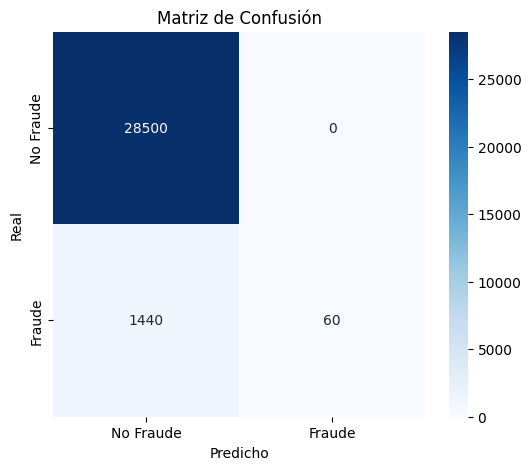

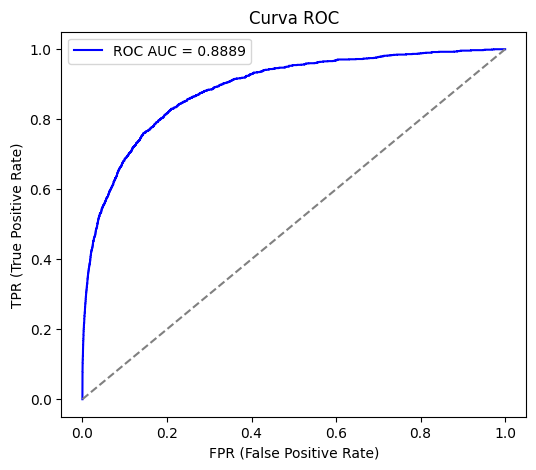

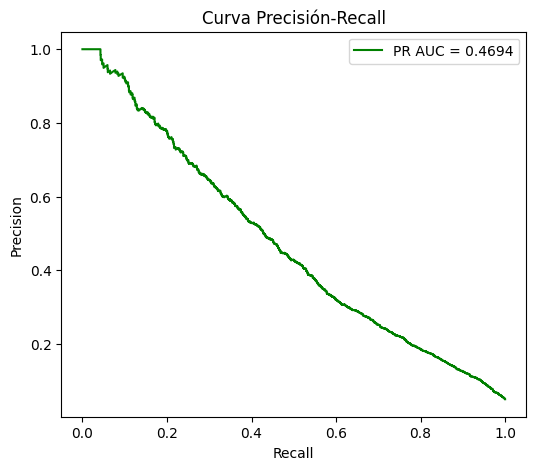


Importancia de Características:
                 Feature  Importance
8                  monto        3616
6                      l        3541
1                      c        3424
0                      b        3412
7                      m        3069
9                  score        3028
5                      h        2381
4                      f        2188
3                      e        2006
2                      d        1695
10             g_encoded         381
21        o_missing_True         311
11     high_risk_product         304
28   high_risk_hour_True         256
25   dia_semana_Thursday         227
26    dia_semana_Tuesday         225
22     dia_semana_Monday         218
15                   n_1         209
23   dia_semana_Saturday         185
27  dia_semana_Wednesday         178


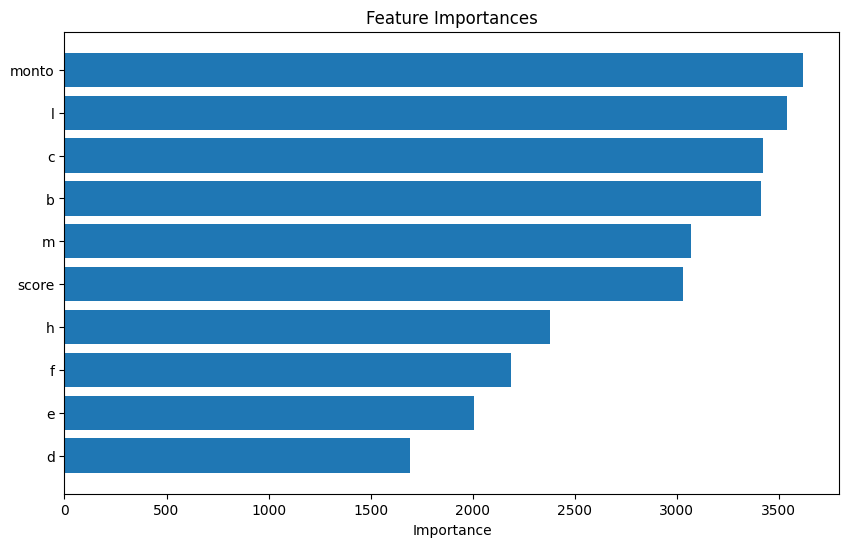

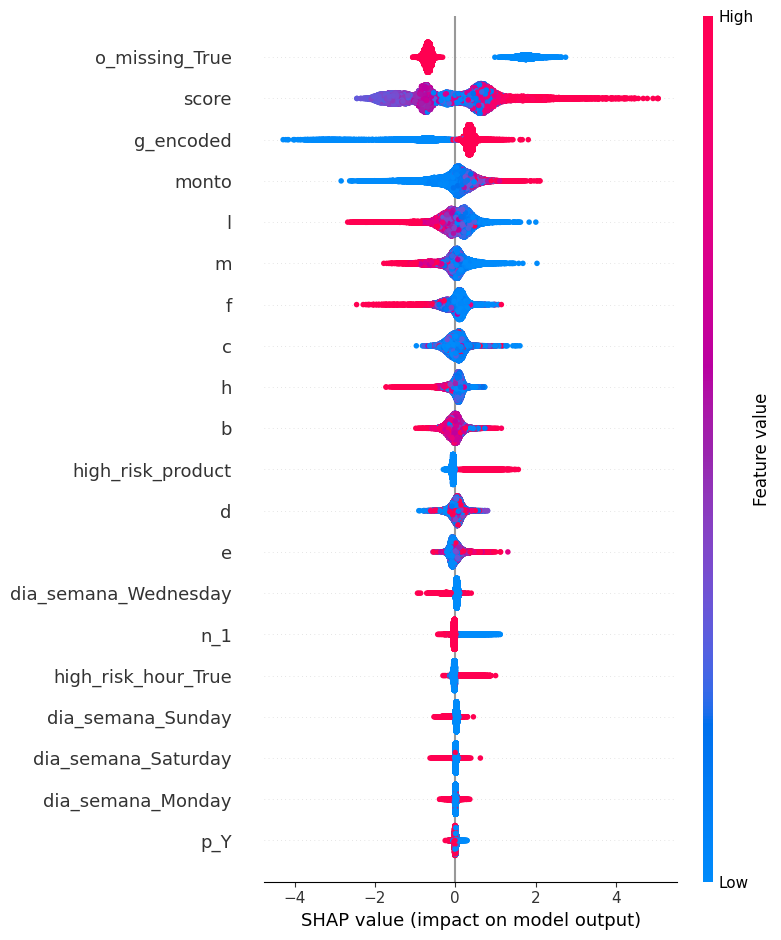

In [86]:
lgbm_cs_uo, umbral_optimo_lgbm_cs = optimize_train_evaluate_op_th(X, y, "LightGBM", "CostSensitive", device="gpu", n_trials=50)

---